### Overview

This is the main file for model training. 

Overview
1. Load data and send into PyTorch batches. Note that there is a separate data augmentation cell (experimental) that is currently commented out. 
2. Define a number of models. The first four models are super resolution architectures. The chosen model is EDSR: enhanced deep residual network. The second models are an experimental GAN, and a VGG network for perceptual loss -- not yet implemented. 
3. Define the quality metric used for training. This is the PSNR, which compares the error between the input and output. The loss function used is MSE loss, which PSNR is the (log) reciprocal of.
4. Define the training loop. 
5. Run the model and produce plots. Capability exists for (a) a learning rate hyperparameter search, (b) storing epoch PSNR in an Excel file and (c) re-training, which appends to the existing Excel file.

The model can be saved for external use or re-training. The bottom of the file contains the experimental GAN training code (not working).

In [19]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import os
import xarray as xr
import matplotlib.pyplot as plt
import copy
import random
import time

#### Load Data
- This code looks at all netcdf files in a particular folder, and appends the chosen channels (default is just the gradient channels) to a single xarray dataset of dimensions (i, channel, y, x). 
- The sample percent can be reduced to speed up training. 
- You can choose whether to include the absolute and gradient channels in the data, or just the gradients, or just the absolutes. 
- Additionally, the variable `prev_next` allows you to use the particular dataset where the previous and next day's L4 are stored (note that this showed little improvement relative to just using one day and not its adjacent days). 
- The code also has a number of normalisation options. The current approach is to not normalise the data at all (since the gradients naturally form a standard Gaussian distribution from (-1,1), but further testing with normalisation is required.  

In [2]:
## load data and place into required form
# input data must be of the form (i, channel, x_data, y_data)

sample_percent = 1# percent of dataset to sample
folder_path = 'lustre_scratch/data/original_data' # folder containing your .nc files
prev_next = False # set to true if you are using previous/next day data

channels = ['gradient']
channel_data_paths = []
for channel in channels: 
    channel_data_paths.append(os.path.join(folder_path, channel))

ds = []

for channel_path in channel_data_paths:
    # find all .nc files in path
    file_list = []
    for file in os.listdir(channel_path): 
        if file.endswith('.nc'): 
            file_list.append(os.path.join(channel_path,file))
    # now sample from valid .nc files
    N_files = len(file_list)
    sample_indices = random.sample(range(N_files), int(sample_percent*N_files))
    ds_list = []
    for index in sample_indices: 
        ds_list.append(xr.open_dataset(file_list[index]))
    ds_temp = xr.concat(ds_list, dim = 'i') # concat all months into single ds
    # now isolate only the sstL4/gRsst data into a dataset to reduce dataset size
    if channel_path.endswith('absolute'):
        ds_temp = xr.Dataset({
            "sstL4": ds_temp.sstL4,
            "gRsst": ds_temp.gRsst}) # isolate only sstL4 and gRsst
        ds.append(ds_temp.expand_dims(dim='channel', axis=1)) # introduce channel dimension for pytorch
    elif channel_path.endswith('gradient'):
        ds_gr = xr.concat([ds_temp.gRsst_x_grad, ds_temp.gRsst_y_grad], dim = 'channel').transpose("i","channel","y","x")
        if prev_next == True: 
            ds_l4 = xr.concat([ds_temp.prev_sstL4_x_grad, ds_temp.prev_sstL4_y_grad,
                              ds_temp.sstL4_x_grad, ds_temp.sstL4_y_grad,
                              ds_temp.next_sstL4_x_grad, ds_temp.next_sstL4_y_grad], dim = 'channel').transpose("i","channel","y","x")
        else:
            ds_l4 = xr.concat([ds_temp.sstL4_x_grad, ds_temp.sstL4_y_grad], dim = 'channel').transpose("i","channel","y","x")
    
def img_normalise(arr, clipped_gradients = True, normalise_type = None):
    if clipped_gradients:
        mini = -1
        maxi = 1
    else: 
        mini = arr.min(dim={'x','y','i'}) #min for each image in each channel: shape (i, channel)
        maxi = arr.max(dim={'x','y','i'})
    if normalise_type == 'zero_one':
        # 0-1 normalise data
        # use this if you will input your data as numpy arrays
        arr = (arr-mini)/(maxi-mini) #normalise each channel to 0-255
    elif normalise_type == 'tensor': 
        # normalise to 0-1 then convert to image values. 
        # use if you plan to use torch.transforms
        arr = 255*(arr-mini)/(maxi-mini) #normalise each channel to 0-255
    return arr
ds_l4 = img_normalise(ds_l4)
ds_gr = img_normalise(ds_gr)
# ds = xr.Dataset({"sstL4": img_normalise(ds.sstL4, clipped_gradients = True, normalise_type = 'zero_one'),
#                  "gRsst": img_normalise(ds.gRsst, clipped_gradients = True, normalise_type = 'zero_one')}) # convert to pixel values

#### Load Batches into DataLoader
- This code defines the `MyDataset` class, which is the standard approach to turning your data into a PyTorch dataset. 
- The data is then separated into batches in the `DataLoader` object.
- There is a test and train dataloader and eventually a validation dataloader should be added. The current standard train:test split is 20%. 
- The dataloder consists of the input: low-res L4 images in the gradient domain (thus, 2 channels) and the output: gradient restored images in the gradient domain. Can also experiment with adding the absolute domain as an additional channel, as described in the above cell.
- An alternate data augmentation approach also exists in the second cell, which aims to address the occurrence of model overfitting. This is so far experimental.

In [3]:
class MyDataset(Dataset): 
    ## this version of the class does not apply tensor transforms
    ## data inserted as numpy arrays in form (i, channel, y, x)
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
    def __getitem__(self, index): 
        x = self.input_data[index]
        y = self.output_data[index]
        return x, y
    def __len__(self):
        return len(self.input_data)
# Convert data to numpy arrays
input_data = ds_l4.sel({'channel': [0, 1]}).data
output_data = ds_gr.sel({'channel': [0, 1]}).data

# Split data into training and test sets
input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=0.2)


# Create dataset and dataloader
train_dataset = MyDataset(input_train, output_train)
test_dataset = MyDataset(input_test, output_test)  # No augmentation for test data

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Check the data loader
for x, y in train_loader: 
    print(f'batch shape: input: {x.shape}, output: {y.shape}, type: {type(x)}')
    print(f'number of batches: {len(train_loader)}')
    print(f'train images: {len(train_loader.dataset)}, test images: {len(test_loader.dataset)}')
    break

In [33]:
# ##### DATA AUGMENTATION EXPERIMENT >> DONT RUN THIS IF YOU DONT WANT

# class MyDataset(Dataset):
#     def __init__(self, input_data, output_data, transform=None, augment_factor=3):
#         self.input_data = input_data
#         self.output_data = output_data
#         self.transform = transform
#         self.augment_factor = augment_factor
        
#         self.augmented_input_data = []
#         self.augmented_output_data = []
        
#         if self.transform:
#             self._augment_data()
        
#     def _augment_data(self):
#         for i in range(len(self.input_data)):
#             x = self.input_data[i]
#             y = self.output_data[i]
            
#             for _ in range(self.augment_factor - 1):  # to triple the dataset
#                 augmented = self.transform(image=x, target=y)
#                 self.augmented_input_data.append(augmented['image'].numpy())
#                 self.augmented_output_data.append(augmented['target'].numpy())
        
#         self.input_data = np.concatenate((self.input_data, np.array(self.augmented_input_data)), axis=0)
#         self.output_data = np.concatenate((self.output_data, np.array(self.augmented_output_data)), axis=0)
    
#     def __getitem__(self, index): 
#         x = self.input_data[index]
#         y = self.output_data[index]
        
#         return x, y
    
#     def __len__(self):
#         return len(self.input_data)

# # Define the augmentation transform
# class AugmentationTransform:
#     def __init__(self):
#         self.augmentations = transforms.Compose([
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomVerticalFlip(p=0.5),
#             transforms.RandomResizedCrop(size=(48, 48))
#         ])
    
#     def __call__(self, image, target):
#         seed = np.random.randint(2147483647)
#         image = torch.tensor(image, dtype=torch.float32)
#         target = torch.tensor(target, dtype=torch.float32)
#         torch.manual_seed(seed)
#         augmented_image = self.augmentations(image)
#         torch.manual_seed(seed)
#         augmented_target = self.augmentations(target)
#         return {'image': augmented_image, 'target': augmented_target}

# # Convert data to numpy arrays (assuming you have xarray data)
# input_data = ds_l4.sel({'channel': [0, 1]}).data
# output_data = ds_gr.sel({'channel': [0, 1]}).data

# # Split data into training and test sets
# input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=0.2)

# # Define augmentation transform
# augment_transform = AugmentationTransform()

# # Create dataset and dataloader
# train_dataset = MyDataset(input_train, output_train, transform=augment_transform)
# test_dataset = MyDataset(input_test, output_test)  # No augmentation for test data

# BATCH_SIZE = 16
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# # Check the data loader
# for x, y in train_loader: 
#     print(f'batch shape: input: {x.shape}, output: {y.shape}, type: {type(x)}')
#     print(f'number of batches: {len(train_loader)}')
#     print(f'train images: {len(train_loader.dataset)}, test images: {len(test_loader.dataset)}')
#     break

batch shape: input: torch.Size([16, 2, 48, 48]), output: torch.Size([16, 2, 48, 48]), type: <class 'torch.Tensor'>
number of batches: 5143
train images: 82281, test images: 6857


In [ ]:
# ## TEST DATA AUGMENTATION
# input_data, output_data = next(iter(train_loader))
# for i in range(len(input_data)):
#     fig,ax=plt.subplots(1,2)
#     ax[0].imshow(input_data[i,0])
#     ax[1].imshow(output_data[i,0])
#     plt.show()

### Define Models

Layer Reference: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
| Paper with super-resolution architectures: https://www.mdpi.com/2072-4292/14/5/1159

- This section contains (a) 4 super-resolution architectures, (b) an experimental GAN approach and (c) a VGG regularisation / perceptual loss pre-trained network.
- The super-res architectures consists of the simple SRCNN and the deeper residual networks with skip connections (last three). Each has the goal of inputting 2 (or more) low-res L4 channels and outputting 2 (or more) gradient restored channels.
- Out of the super-res architectures, the EDSR has proven most succesful in terms of time-to-train and quality. But further work must be done to enhance the more complex ADSR-SR and DADR-SR architectures with batch normalisation, dropout etc. The number of filters, kernel size and residual blocks must also be varied and tested. 
- The GAN architecture is currently dysfunctional. The GAN training code can be found at the bottom of the notebook. 
- The VGG network is intended as a loss regularisation term, to be added to the loss output from the chosen network. VGG is used for feature extraction, which can be performed on the prediction and the ground truth gradient restored data.

#### SRCNN

In [48]:
class SRCNN(nn.Module):
    def __init__(self, input_channels = 1, output_channels = 1):
        # define layers
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 128, kernel_size=9, stride=1, padding='same')
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(64, 32, kernel_size=5, stride=1, padding='same')
        self.conv4 = nn.Conv2d(32, output_channels, kernel_size=1, stride=1, padding='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

#### EDSR

In [43]:
class ERes_Block(nn.Module):
    # enhanced residual block
    def __init__(self, input_channels = 64):
        # define layers
        super(ERes_Block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.bn1 = nn.BatchNorm2d(64)
        # must return same no. of channels as inputted
        self.conv2 = nn.Conv2d(64, input_channels, kernel_size = 3, stride = 1, padding = 'same')
        self.bn2 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
    def forward(self, x):
        x_skip = x # save for skip connection
        x = self.dropout(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.bn2(self.conv2(x) * 0.1))
        x = torch.add(x,x_skip) # add copy to x
        return x
        
class EDSR(nn.Module): 
    def __init__(self, input_channels = 1, output_channels = 1, N_blocks=16):
        # define layers
        super(EDSR, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size = 3, dilation=1, padding = 'same') # dilation=1
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size = 3, padding = 'same')
        self.erb = ERes_Block(64)
        self.N_blocks = N_blocks
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.bn = nn.BatchNorm2d(64)
    def forward(self, x):
        x=x.float()
        x=self.dropout(self.relu(self.bn(self.conv1(x))))
        x_skip = x
        ## 16 residual blocks
        for _ in range(self.N_blocks):
            x = self.erb(x)
        x = self.dropout(self.relu(self.bn(self.conv2(x))))
        x = torch.add(x,x_skip)
        x = self.dropout(self.conv3(x))
        return x

#### ADR-SR

In [36]:
class ARes_Block(nn.Module):
    # adaptive residual block
    def __init__(self, input_channels = 32, output_channels = 32):
        # define layers
        super(ARes_Block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 192, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv2d(192, input_channels, kernel_size = 3, stride = 1, padding = 'same')
        self.global_pool = nn.AvgPool2d(kernel_size = 48) # pool over entire 48x48 image, applied separately to each channel, returns 32x2 vector (2 channels)
        self.fc1 = nn.Linear(32, 2)
        self.fc2 = nn.Linear(2, 32)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x_skip = x # save for skip connection
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x_pre_scaling = x
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for input into fc layer
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x)) # scaling factors for each channel
        x = x.view(x.size(0), x.size(1), 1, 1)
        x = torch.mul(x_pre_scaling, x) # scaled x 
        x = torch.add(x, x_skip)
        return x
    
class ADR_SR(nn.Module):
    def __init__(self, input_channels = 1, output_channels = 1, N_blocks=16):
        # define layers
        super(ADR_SR, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size = 3, dilation=1, padding = 'same') # dilation=1
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(32, output_channels, kernel_size = 3, padding = 'same')
        self.arb = ARes_Block(32)
        self.N_blocks = N_blocks
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x_skip = x
        for _ in range(self.N_blocks):
            x = self.arb(x)
        x = self.relu(self.conv2(x))
        x = torch.add(x, x_skip)
        x = self.conv3(x)
        return x   

#### DADR-SR

In [51]:
class Multiscale_ARes_Block(nn.Module):
    def __init__(self, input_channels = 30):
        super(Multiscale_ARes_Block, self).__init__()
        # dilation layers
        self.dilated1_1 = nn.Conv2d(input_channels, 120, kernel_size = 3, dilation = 1, padding = 'same')
        self.dilated1_2 = nn.Conv2d(120, 10, kernel_size = 3, dilation = 1, padding = 'same')
        self.dilated2_1 = nn.Conv2d(input_channels, 120, kernel_size = 3, dilation = 3, padding = 'same')
        self.dilated2_2 = nn.Conv2d(120, 10, kernel_size = 3, dilation = 3, padding = 'same')
        self.dilated3_1 = nn.Conv2d(input_channels, 120, kernel_size = 3, dilation = 5, padding = 'same')
        self.dilated3_2 = nn.Conv2d(120, 10, kernel_size = 3, dilation = 5, padding = 'same')
        # adaptive scaling layer
        self.global_pool = nn.AvgPool2d(kernel_size = 48) # pool over entire 48x48 image, applied separately to each channel, returns 32x2 vector (2 channels)
        self.fc1 = nn.Linear(30, 3)
        self.fc2 = nn.Linear(3, 30)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x_skip = x
        x1_1 = self.dilated1_1(x)
        x1_2 = self.dilated1_2(x1_1)
        x2_1 = self.dilated2_1(x)
        x2_2 = self.dilated2_2(x2_1)
        x3_1 = self.dilated3_1(x)
        x3_2 = self.dilated3_2(x3_1)
        x = torch.cat((x1_2, x2_2, x3_2), 1)
        x_pre_scaling = x
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for input into fc layer
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x)) # scaling factors for each channel
        x = x.view(x.size(0), x.size(1), 1, 1)
        x = torch.mul(x_pre_scaling, x) # scaled x 
        x = torch.add(x, x_skip)
        return x 

class DADR_SR(nn.Module):
    def __init__(self, input_channels = 1, output_channels = 1, N_blocks = 12):
        super(DADR_SR, self).__init__()
        self.dilated1 = nn.Conv2d(input_channels, 10, kernel_size = 3, dilation = 1, padding = 'same')
        self.dilated2 = nn.Conv2d(input_channels, 10, kernel_size = 3, dilation = 3, padding = 'same')
        self.dilated3 = nn.Conv2d(input_channels, 10, kernel_size = 3, dilation = 5, padding = 'same')
        self.marb = Multiscale_ARes_Block(30)
        self.N_blocks = N_blocks
        self.dilated4 = nn.Conv2d(30, 30, kernel_size = 3, dilation = 1, padding = 'same')
        self.dilated5 = nn.Conv2d(30, output_channels, kernel_size = 3, dilation = 1, padding = 'same')
    def forward(self, x):
        x1 = self.dilated1(x)
        x2 = self.dilated2(x)
        x3 = self.dilated3(x)
        x = torch.cat((x1,x2,x3), 1)
        x_skip = x
        for _ in range(self.N_blocks):
            x = self.marb(x)
        x = self.dilated4(x)
        x = torch.add(x, x_skip)
        x = self.dilated5(x)
        return x

# model = DADR_SR(2, 2)   
# x = torch.rand(4, 2, 48, 48)
# y = model(x)
# y.shape

#### VGG Perceptual Loss

(torch.Size([100, 3, 48, 48]), torch.Size([100, 3, 48, 48]))

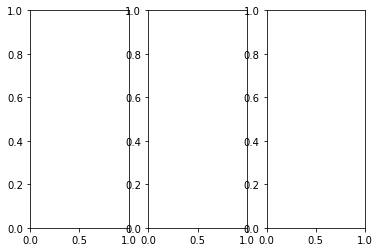

In [52]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layers=[0, 5, 10, 19, 28], device='cuda'):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features
        self.layers = layers  # Select layers to use for perceptual loss
        self.perceptual_encoder = nn.Sequential(*list(vgg)[:4]).to(device).eval()  #
        for param in self.perceptual_encoder.parameters():
            param.requires_grad = False
        self.device = device

    def forward(self, predicted, ground_truth):
        predicted_x = torch.select(predicted,1,0).unsqueeze(1).repeat(1,3,1,1)
        predicted_y = torch.select(predicted,1,1).unsqueeze(1).repeat(1,3,1,1)
        
        ground_truth_x = torch.select(ground_truth_x,1,0).unsqueeze(1).repeat(1,3,1,1)
        ground_truth_y = torch.select(ground_truth_y,1,1).unsqueeze(1).repeat(1,3,1,1)
        
        predicted_6channel = predicted.repeat(1, 3, 1, 1).to(self.device) # duplicate into RGB
        ground_truth_6channel = ground_truth.repeat(1, 3, 1, 1).to(self.device)
       
        predicted_features = self.perceptual_encoder(predicted_6channel)
        ground_truth_features = self.perceptual_encoder(ground_truth_6channel)
        #  perceptual loss (MSE between VGG features)
        loss = nn.MSELoss()(predicted_features, ground_truth_features)

        return loss
    
    
# x = torch.randn(1,2,48,48)
# fig,ax=plt.subplots(1,2)
# ax[0].imshow(x.numpy()[0,1])
# ax[1].imshow(x.numpy()[0,0])
# x= x.repeat(1,3,1,1)
# fig,ax=plt.subplots(1,6)
# for i in range(6):
#     ax[i].imshow(x.numpy()[0,i])

x,y=torch.randn(100,2,48,48),torch.randn(100,2,48,48)
x_x = torch.select(x,1,0).unsqueeze(1).repeat(1,3,1,1)
x_y = torch.select(x,1,1).unsqueeze(1).repeat(1,3,1,1)
fig,ax=plt.subplots(1,3)
x_x.size(),x_y.size()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = VGGPerceptualLoss(device)
# loss=model(x,y)
# print(loss)

#### GAN

In [53]:
## EXPERIMENTAL
class Generator(nn.Module):
    def __init__(self, input_channels = 2, output_channels = 2): 
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.dropout = nn.Dropout(0.2)
        self.fc_in = nn.Linear(2304, 64)
        self.fc_out = nn.Linear(64, 2304)
        self.tconv1 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1)
        self.tconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.tconv3 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 2, padding = 1)
        self.tconv4 = nn.ConvTranspose2d(64, output_channels, kernel_size = 4, stride = 2, padding = 1)
        self.relu = nn.ReLU()

    def forward(self, x): 
        batch = x.size(0)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(batch,-1)
        x = self.dropout(self.relu(self.fc_in(x)))
        x = self.dropout(self.relu(self.fc_out(x)))
        x = torch.reshape(x, (batch, 256,3,3))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.relu(self.tconv4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_channels = 2): 
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 'same')
        self.fc = nn.Linear(73728, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): 
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x)) 
        x = x.view(x.size(0),-1)
        x = self.sigmoid(self.fc(x))
        return x

### Define PSNR Accuracy Metric
PSNR is defined as: $10 \cdot \log_{10}\left(\frac{\text{MAX}^2I}{MSE}\right)$ where $\text{MAX}^2 I$ is the max of the image and $\text{MSE}$ is the mean-squared error between the gradient restored image and the model prediction. The optimiser used in training is `MSELoss`, which aims to minimise the MSE between the output and ground truth. Hence, the model aims to *maximise* the PSNR. 

In [6]:
def PSNR(model, ground_truth, prediction):
    # ground truth, pred inputted as numpy arrays of dimensions (image index, channel, y, x)
    # if channel > 1, sum MSE over each channel
    # return: avg psne for input data
    model.eval()
    # image dimensions
    m = np.ma.size(ground_truth, axis = 2)
    n = np.ma.size(ground_truth, axis = 3)
    # compute mse and sum over channels
    mse_array = np.sum(((ground_truth-prediction))**2, axis = (1,2,3))/(m*n) # sum over (x,y) i.e. (2,3)
    # compute mean of mse over all images in batch
    mse_avg = np.mean(mse_array)
    # convert to psnr
    psnr_avg = 10*np.log10(1**2/mse_avg)
    return psnr_avg
# rand1 = np.random.uniform(size=(64,2,48,48))
# rand2 = np.random.uniform(size=(64,2,48,48))
# PSNR(model,rand1,rand2)

### Define Quality Plot
Plot the PSNR for test and train as a function of epochs.

In [7]:
def quality_plot(train_epochs, train_psnr_array, test_epochs, test_psnr_array, test_interval, lr, plot_path, save = False):
    plt.plot(train_epochs, train_psnr_array, label = 'train')
    plt.plot(test_epochs, test_psnr_array, label = 'test')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.grid()
    plt.legend()
    plt.title(f'Quality Metrics: Learning Rate: {lr}, Batch Size: {BATCH_SIZE}, Input Channels: {input_channels}')    
    if save == True: 
        plt.savefig(plot_path)
    plt.show()

### Define Train Function

Define the training loop. 
- The training loop loops through batches and computes the model prediction for each batch. The MSE loss between the output and ground truth is computed and model weights are updated in the direction of minimum MSE. 
- The PSNR, which is inversely correlated to the MSE, is stored in separate excel files as well as numpy arrays. 
- The interval at which to apply the model to the test data can be chosen. 
- The model that produces the best test PSNR is actively saved and outputted in the chosen path. 
- The time to completion based on linear extrapolation is also computed.

In [41]:
N_train_batches = len(train_loader)
N_test_batches = len(test_loader)

def train(model, train_loader, test_loader, model_path, psnr_path, retrain=False, num_epochs=100, test_interval=10, display = True):
    lr = optimiser.param_groups[-1]['lr']
    # where to output excel files of training/test quality
    train_psnr_path = os.path.join(psnr_path, f'train_psnr_{lr}.csv')
    test_psnr_path = os.path.join(psnr_path, f'test_psnr_{lr}.csv')
    
    # if retraining, load into arrays the previous excel file for this model. else define new ones
    if retrain:
        train_data = np.loadtxt(train_psnr_path, delimiter=',')
        test_data = np.loadtxt(test_psnr_path, delimiter=',')
        train_epochs = train_data[:, 0].astype(int)
        train_psnr_array = train_data[:, 1]
        test_epochs = test_data[:, 0].astype(int)
        test_psnr_array = test_data[:, 1]
        best_psnr = np.max(train_psnr_array)
    else:
        train_epochs = np.array([])
        train_psnr_array = np.array([])
        test_epochs = np.array([])
        test_psnr_array = np.array([])
        best_psnr = -1000

    t_initial = time.time()
    for epoch in range(num_epochs):
        train_running_psnr = 0
        # iterate through train batches
        for i, (train_input, train_true) in enumerate(train_loader, 0): 
            train_input = train_input.to(device)
            train_true = train_true.to(device)
            optimiser.zero_grad() # re-set grads from previous batch
            train_predicted = model(train_input)
            train_loss = loss_fn(train_true, train_predicted) # loss for batch
            train_loss.backward() # backpropagation
            optimiser.step() # adjust parameters based on grad
            train_running_psnr += PSNR(model, train_true.detach().cpu().numpy(), train_predicted.detach().cpu().numpy())
        
        if len(train_epochs) == 0:
            train_epochs = np.append(train_epochs, 1)
        else:
            train_epochs = np.append(train_epochs, np.max(train_epochs)+1)
        train_psnr_array = np.append(train_psnr_array, train_running_psnr/N_train_batches)
        np.savetxt(train_psnr_path, np.column_stack((train_epochs, train_psnr_array)), delimiter=',')
        
        # every test_interval epochs, compute the test loss. 
        if epoch % test_interval == test_interval - 1: 
            model.eval()
            test_running_psnr = 0
            for i, (test_input, test_true) in enumerate(test_loader, 0): 
                test_input = test_input.to(device)
                test_true = test_true.to(device)
                with torch.no_grad(): 
                    test_predicted = model(test_input)
                    test_running_psnr += PSNR(model, test_true.detach().cpu().numpy(), test_predicted.detach().cpu().numpy())
            if len(test_epochs) == 0:
                test_epochs = np.append(test_epochs, epoch+1)
            else:  
                test_epochs = np.append(test_epochs, np.max(test_epochs)+test_interval)
            test_psnr_array = np.append(test_psnr_array, test_running_psnr/N_test_batches)
            np.savetxt(test_psnr_path, np.column_stack((test_epochs, test_psnr_array)), delimiter=',')
            # store the best model
            if test_psnr_array[-1] > best_psnr: 
                best_model = copy.deepcopy(model)
                best_psnr = test_psnr_array[-1]
                torch.save(best_model.state_dict(), model_path)
            time_elapsed = time.time() - t_initial
            ttc = ((time_elapsed/(epoch+1))*num_epochs-time_elapsed)/3600
            # print the current best PSNR's, and the predicted time to completion. Print the quality plots
            if display:
                print(f'Epoch: {epoch+1}, Train PSNR: {train_psnr_array[-1]}, Test PSNR: {test_psnr_array[-1]}, Best PSNR: {best_psnr}, ttc = {ttc:.2f} hours')
                quality_plot(train_epochs, train_psnr_array, test_epochs, test_psnr_array, test_interval, lr, 'e')

    return best_model, train_epochs, train_psnr_array, test_epochs, test_psnr_array


### Run Training
Define learning rate, optimiser and loss function, and run the training process.
- You may choose to do a logarithmic learning rate search (uncomment np.random.uniform). If not, just add the single desired learning_rate to the lr_search array.
- A pre-trained model and be reloaded for further training. 
- To simply load the model for testing visual performance (see later cell), set `train_model = False`. 
- Also write the path where the model parameters are to be stored, as well as the PSNR test/train data.
- Set `display = False` to avoid plotting below.

Epoch: 1, Train PSNR: 17.16703132990088, Test PSNR: 19.12652147673643, Best PSNR: 19.12652147673643, ttc = 16.46 hours


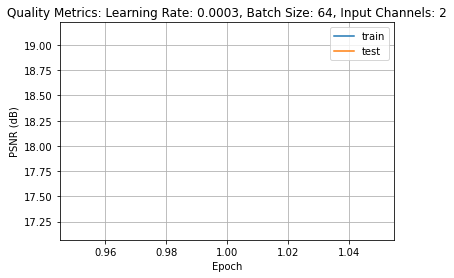

Epoch: 2, Train PSNR: 19.277281478083474, Test PSNR: 19.34810610131974, Best PSNR: 19.34810610131974, ttc = 16.48 hours


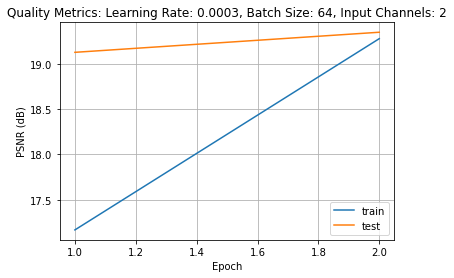

Epoch: 3, Train PSNR: 19.429839925493166, Test PSNR: 19.465727567876776, Best PSNR: 19.465727567876776, ttc = 16.47 hours


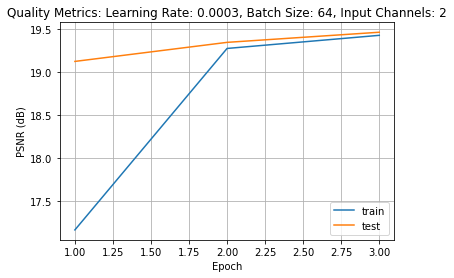

Epoch: 4, Train PSNR: 19.523153779792825, Test PSNR: 19.538981916365817, Best PSNR: 19.538981916365817, ttc = 16.45 hours


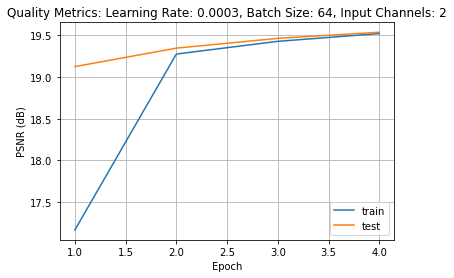

Epoch: 5, Train PSNR: 19.587019475402997, Test PSNR: 19.601113889987708, Best PSNR: 19.601113889987708, ttc = 16.44 hours


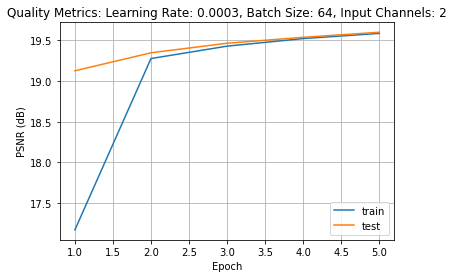

Epoch: 6, Train PSNR: 19.63504138197284, Test PSNR: 19.637024072000653, Best PSNR: 19.637024072000653, ttc = 16.43 hours


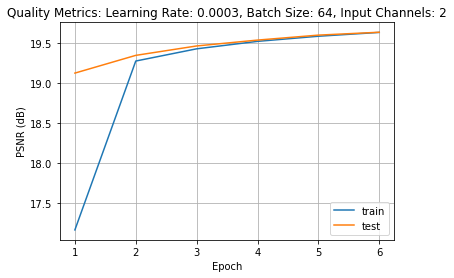

Epoch: 7, Train PSNR: 19.666281183357714, Test PSNR: 19.658834549744615, Best PSNR: 19.658834549744615, ttc = 16.41 hours


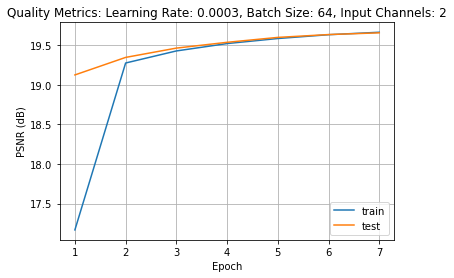

Epoch: 8, Train PSNR: 19.69507543388028, Test PSNR: 19.679931383717285, Best PSNR: 19.679931383717285, ttc = 16.39 hours


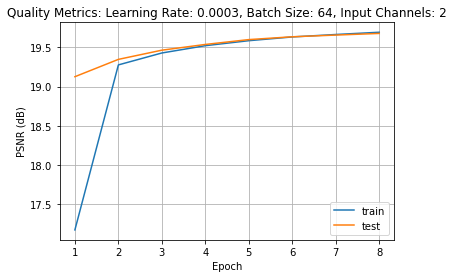

Epoch: 9, Train PSNR: 19.717199081327635, Test PSNR: 19.68726747526734, Best PSNR: 19.68726747526734, ttc = 16.38 hours


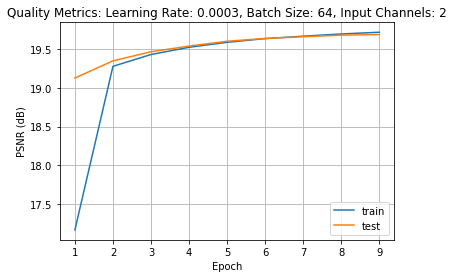

Epoch: 10, Train PSNR: 19.72251968776875, Test PSNR: 19.709875093344333, Best PSNR: 19.709875093344333, ttc = 16.36 hours


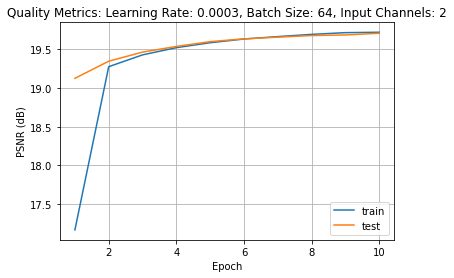

Epoch: 11, Train PSNR: 19.73372220726758, Test PSNR: 19.721601950181746, Best PSNR: 19.721601950181746, ttc = 16.35 hours


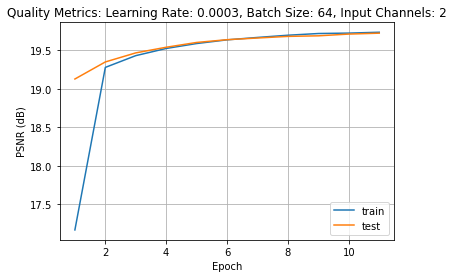

Epoch: 12, Train PSNR: 19.747692987159585, Test PSNR: 19.729419747674143, Best PSNR: 19.729419747674143, ttc = 16.33 hours


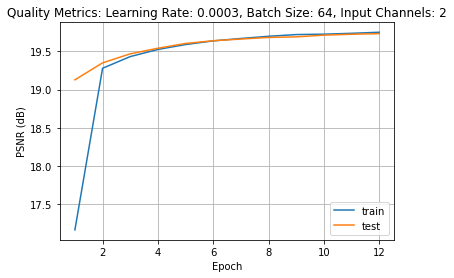

Epoch: 13, Train PSNR: 19.756455424437068, Test PSNR: 19.71822696969056, Best PSNR: 19.729419747674143, ttc = 16.32 hours


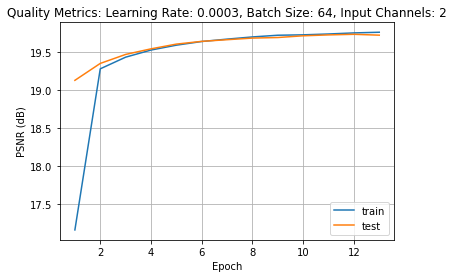

Epoch: 14, Train PSNR: 19.763178650215174, Test PSNR: 19.740994009672104, Best PSNR: 19.740994009672104, ttc = 16.30 hours


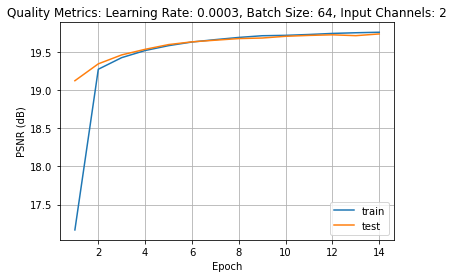

Epoch: 15, Train PSNR: 19.7659195499658, Test PSNR: 19.74560710247964, Best PSNR: 19.74560710247964, ttc = 16.29 hours


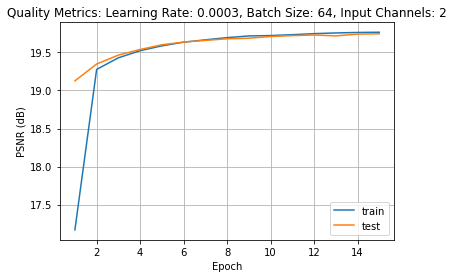

Epoch: 16, Train PSNR: 19.7827120516648, Test PSNR: 19.749488843395916, Best PSNR: 19.749488843395916, ttc = 16.27 hours


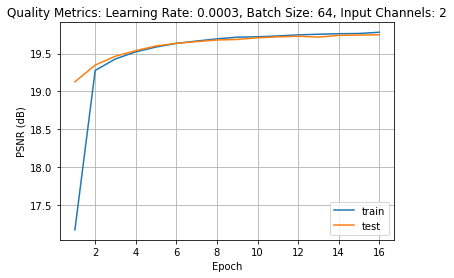

Epoch: 17, Train PSNR: 19.784062305003697, Test PSNR: 19.75154131328863, Best PSNR: 19.75154131328863, ttc = 16.26 hours


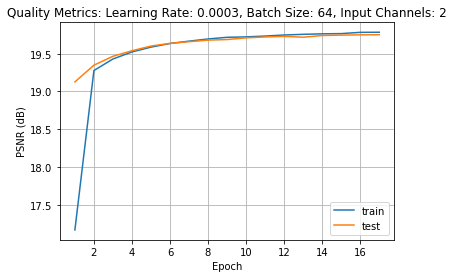

Epoch: 18, Train PSNR: 19.783483131853338, Test PSNR: 19.759450861612574, Best PSNR: 19.759450861612574, ttc = 16.24 hours


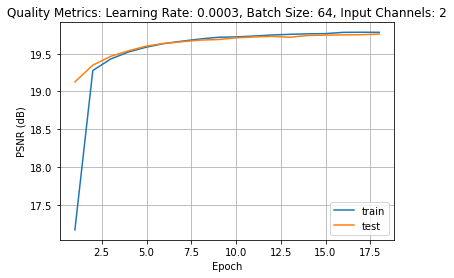

Epoch: 19, Train PSNR: 19.79507731943531, Test PSNR: 19.766990504880468, Best PSNR: 19.766990504880468, ttc = 16.23 hours


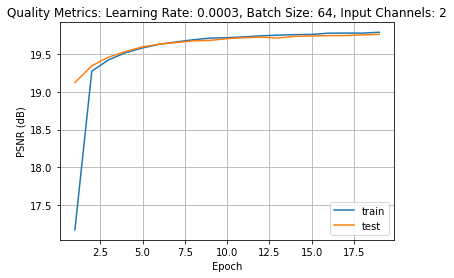

Epoch: 20, Train PSNR: 19.799567967514168, Test PSNR: 19.762051747457125, Best PSNR: 19.766990504880468, ttc = 16.21 hours


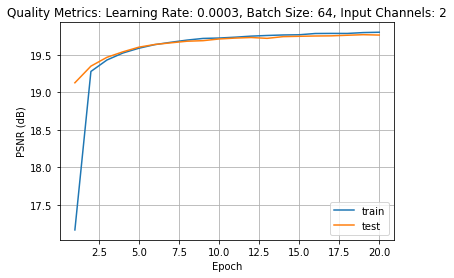

Epoch: 21, Train PSNR: 19.801770824357206, Test PSNR: 19.778204012883535, Best PSNR: 19.778204012883535, ttc = 16.20 hours


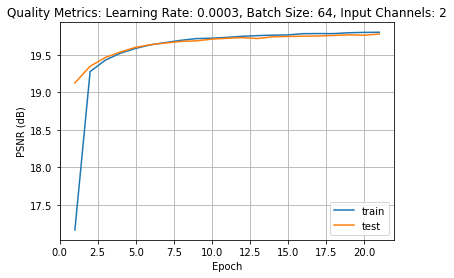

Epoch: 22, Train PSNR: 19.811672191858957, Test PSNR: 19.78899193086695, Best PSNR: 19.78899193086695, ttc = 16.18 hours


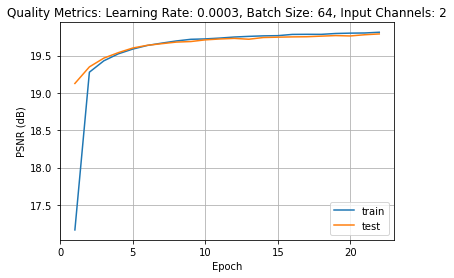

In [ ]:
## remember to re-run this to restart model training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If retraining the same model, remember to use the same psnr_path! 
# Recommended to have a folder for each model where you also store the psnr data. 

reload = False
train_model = True
lr_search = [3E-4] #10**(np.random.uniform(low=-4.7, high=-4.5, size=(10,)))

psnr_path = 'models/edsr_dropout' # where you will store the model quality metrics.

input_channels, output_channels = 2, 2

for lr in lr_search: 
    model_name = f'EDSR_dropout_test1'
    model_path = os.path.join('models/edsr_dropout', model_name) # either for saving or loading
    model = EDSR(input_channels, output_channels, N_blocks=16)

    if reload:
        model.load_state_dict(torch.load(model_path))
    model.to(device)
    if train_model:
        loss_fn = nn.MSELoss(reduction = 'mean')
        optimiser = Adam(model.parameters(), lr = lr)
        best_model, train_epochs, train_psnr_array, test_epochs, test_psnr_array = train(model,train_loader,test_loader,model_path,psnr_path,num_epochs=1000,test_interval=1)

### Plot quality metrics

In [ ]:
quality_plot(train_epochs, train_psnr_array, test_epochs, test_psnr_array, test_interval, save = True, plot_path = 'plots/DADR_SR_1000_epochs-filtered')

### Plot output examples
Look at a single batch and plot the L4, gradient-restored ground truth, and the model prediction. Good for testing the visual performance of the model.

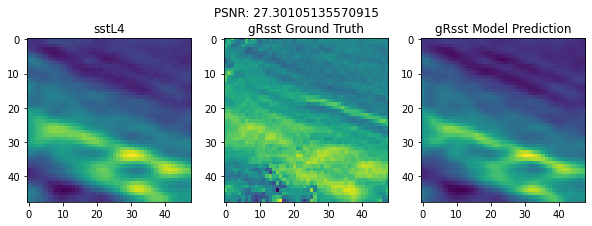

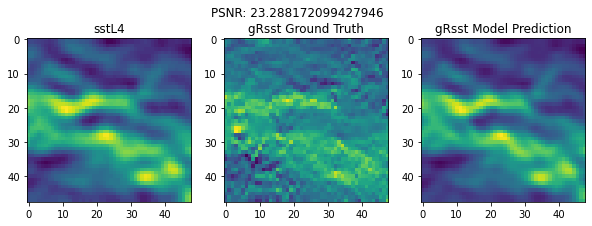

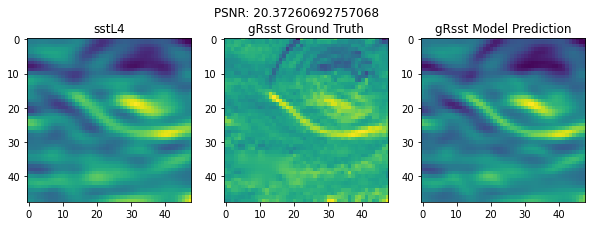

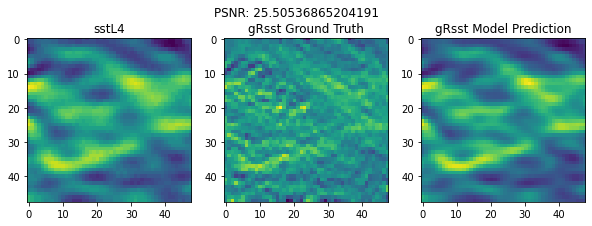

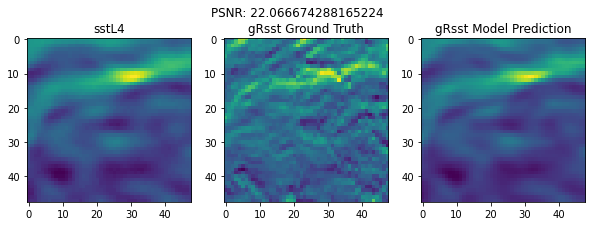

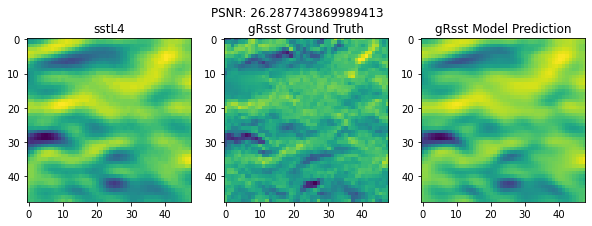

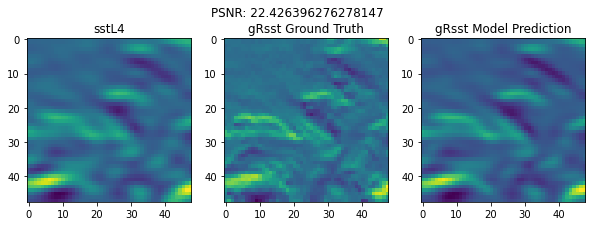

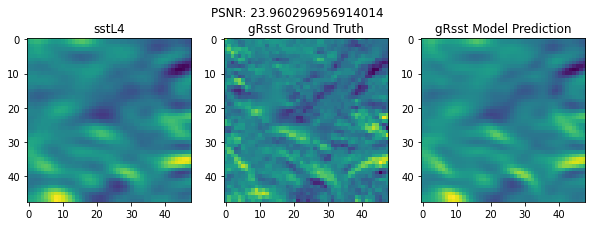

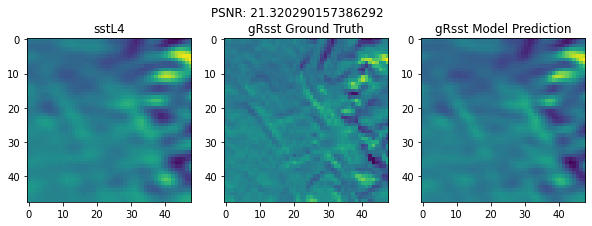

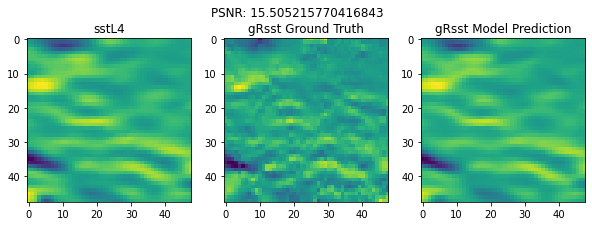

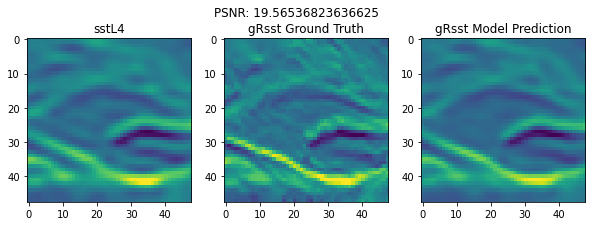

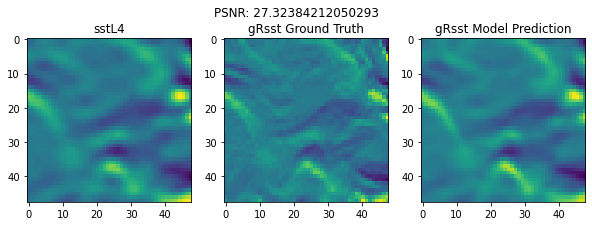

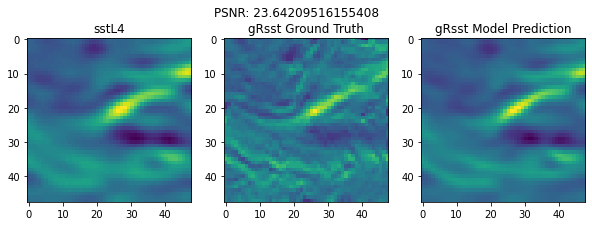

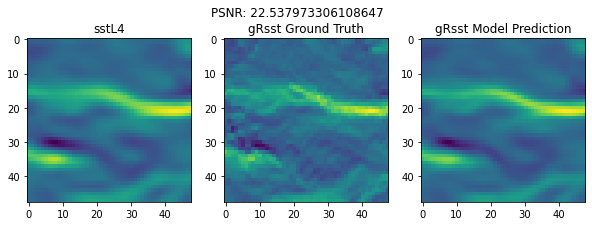

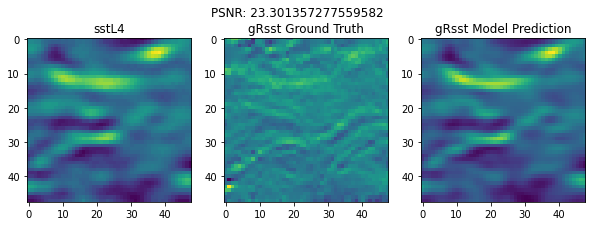

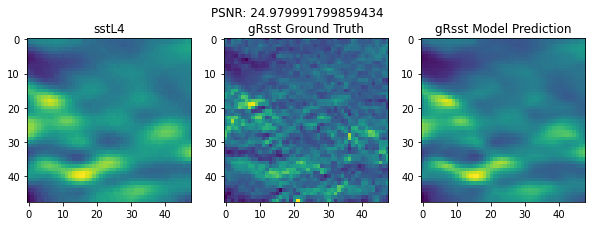

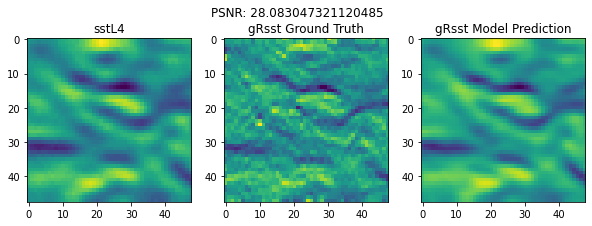

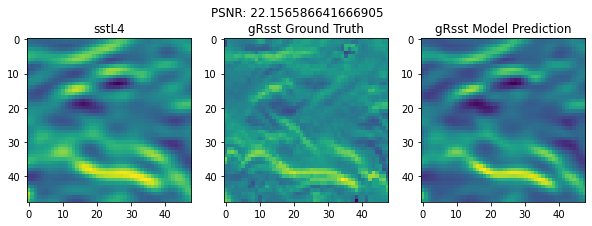

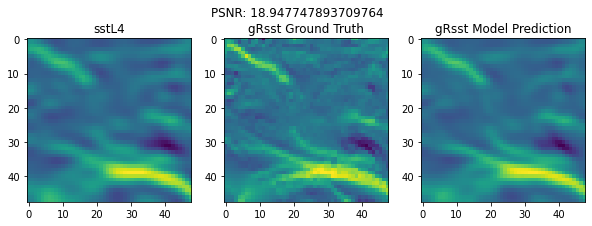

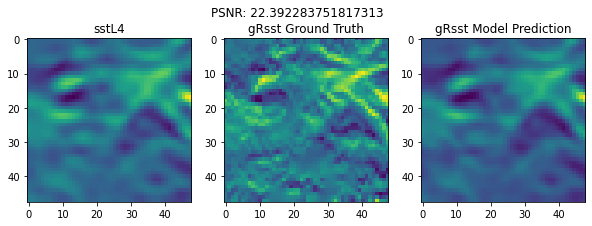

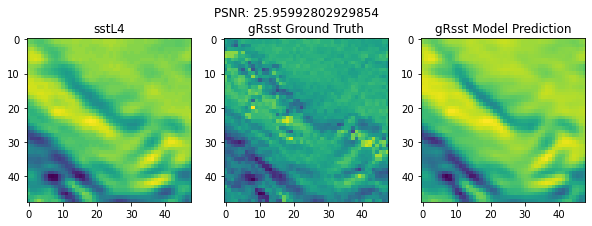

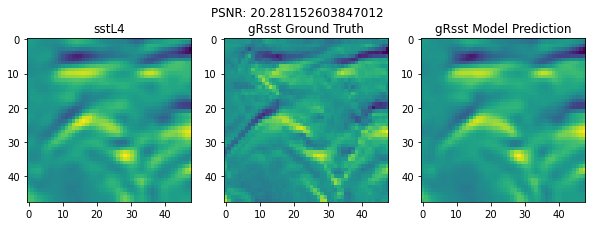

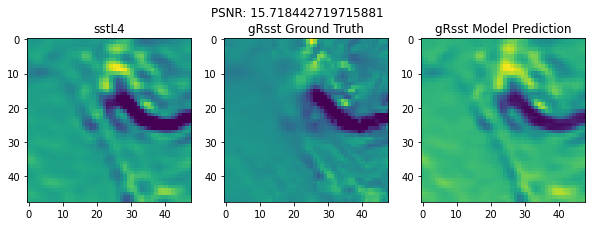

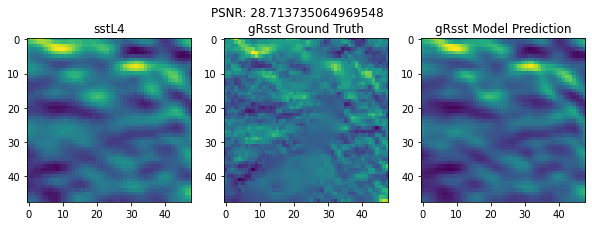

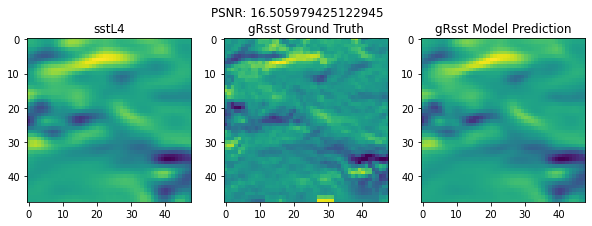

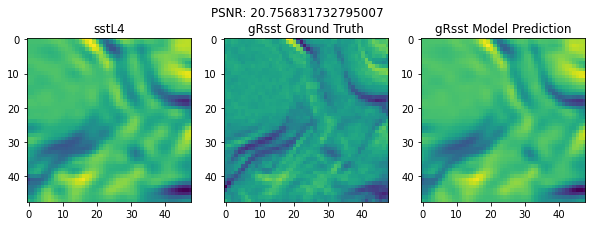

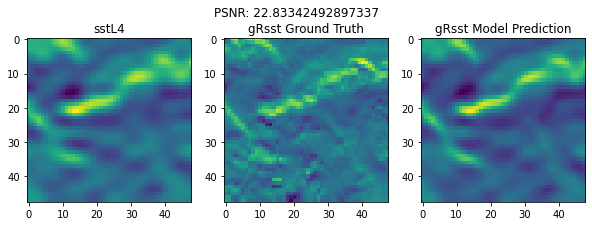

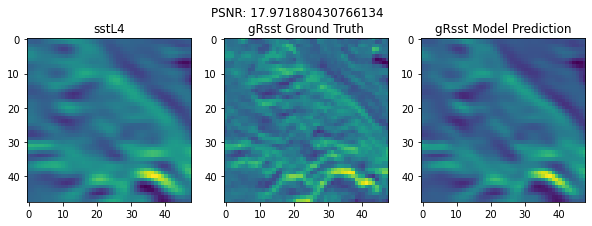

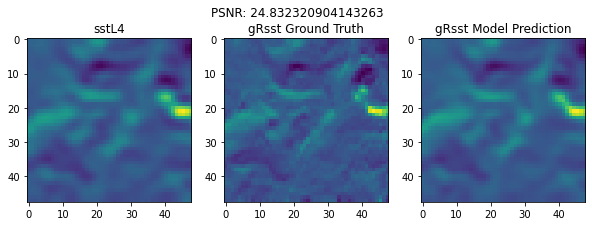

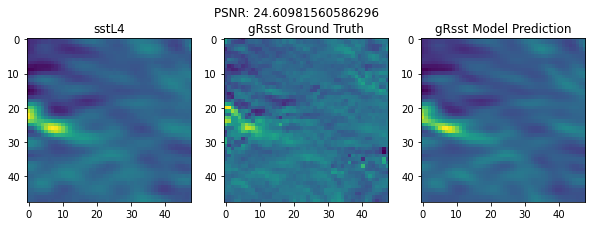

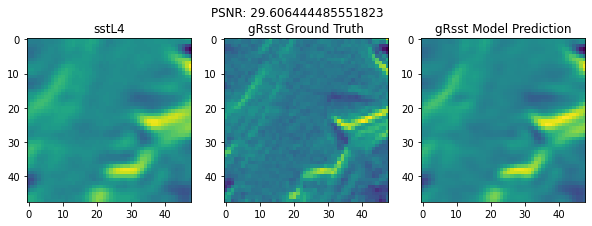

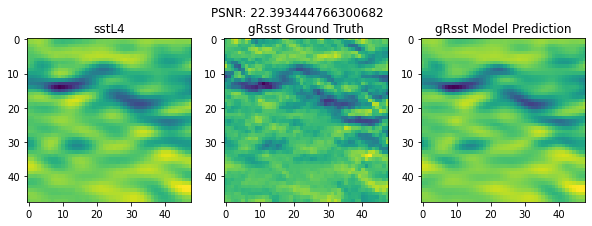

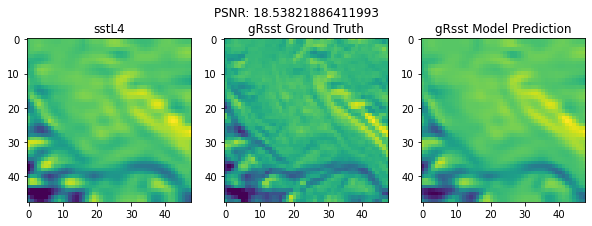

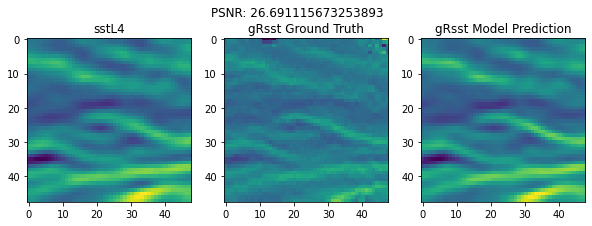

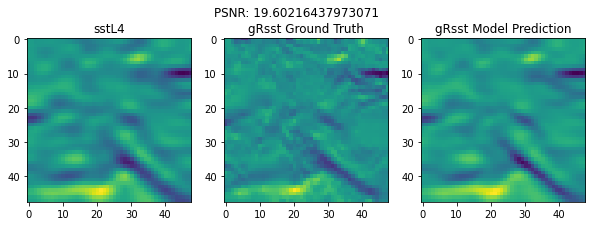

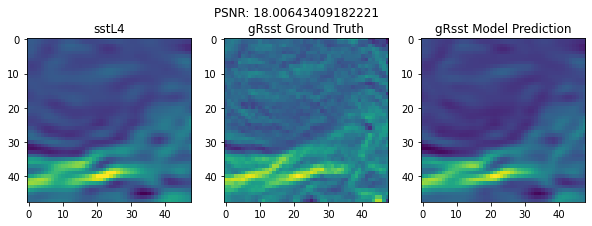

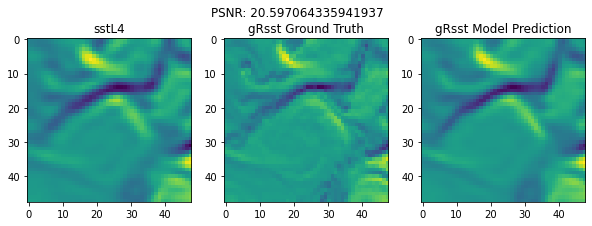

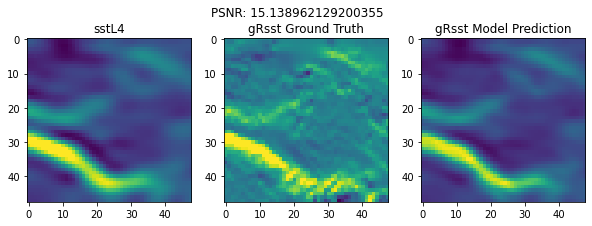

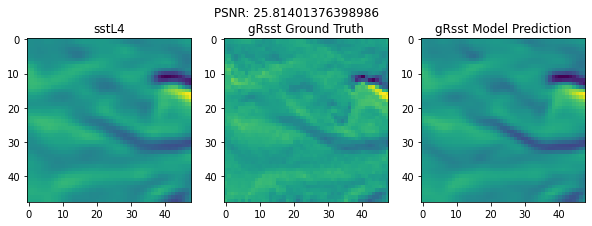

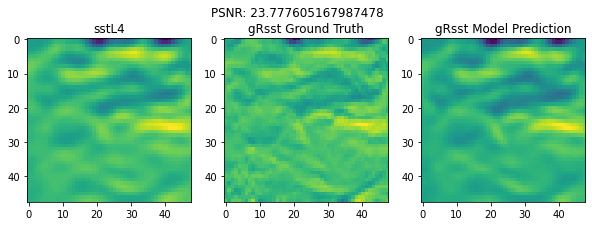

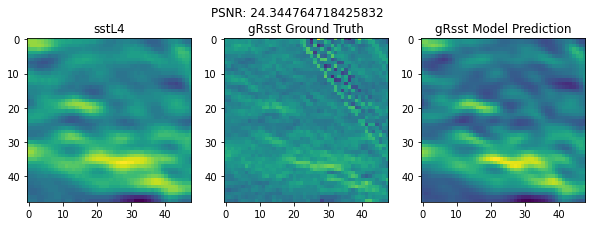

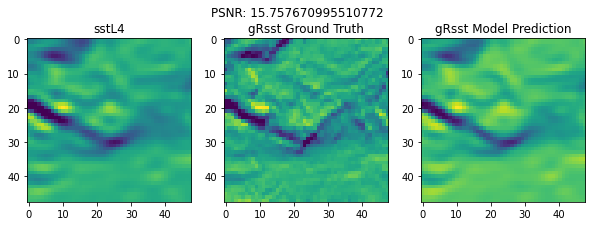

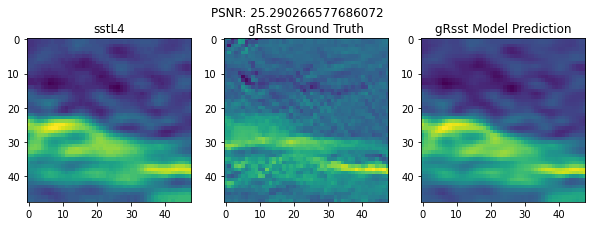

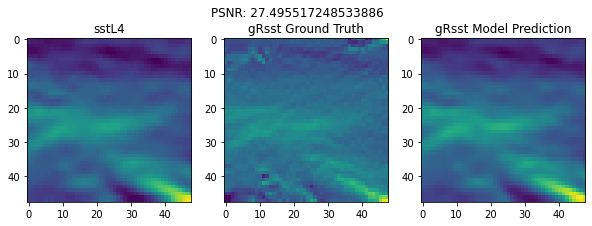

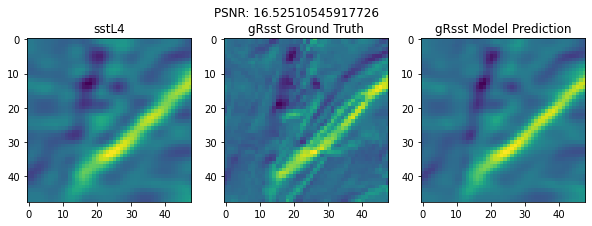

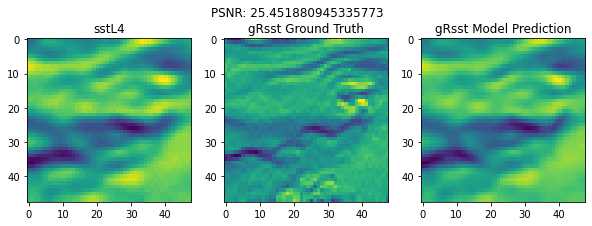

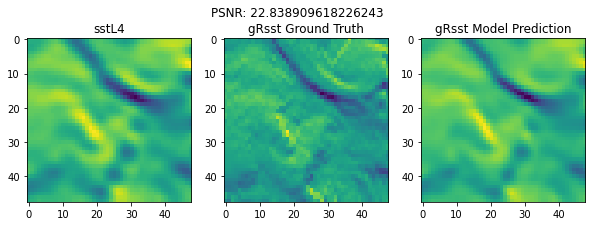

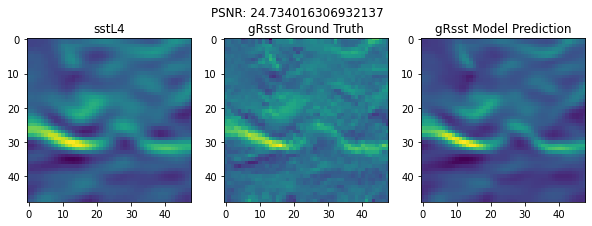

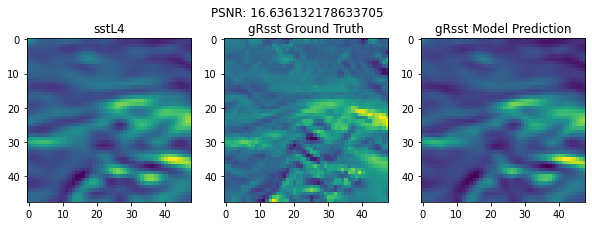

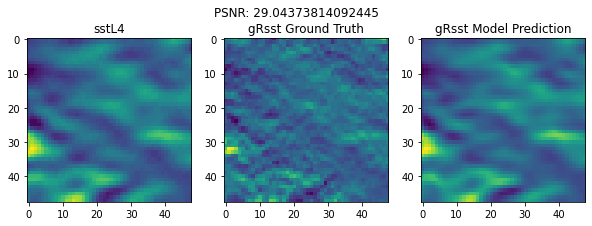

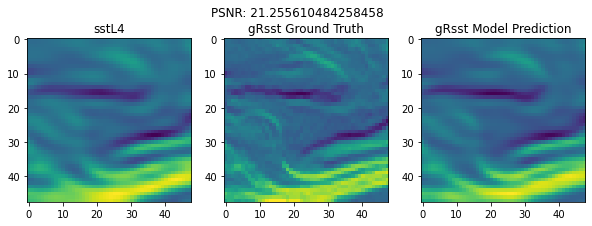

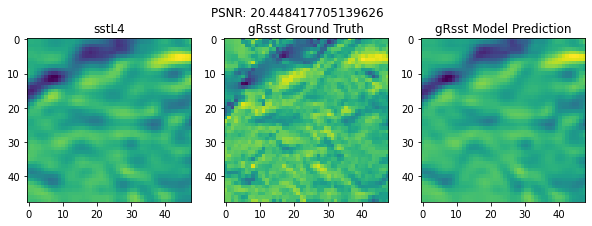

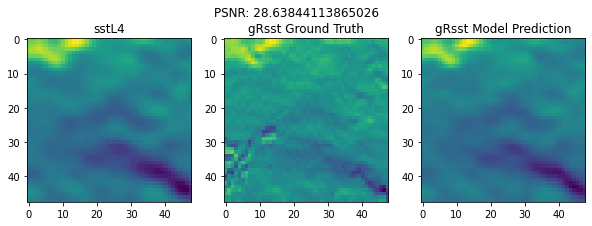

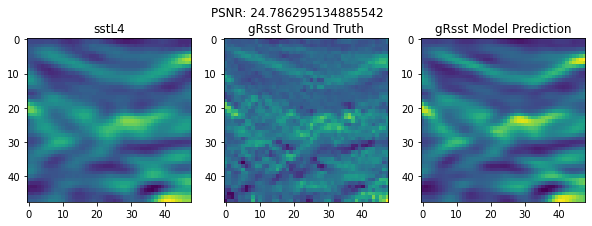

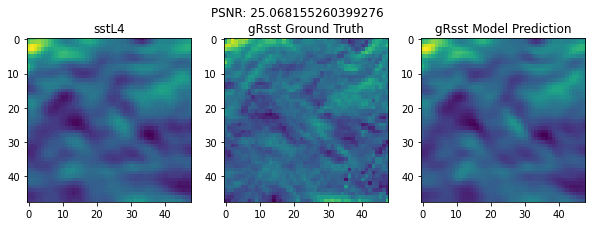

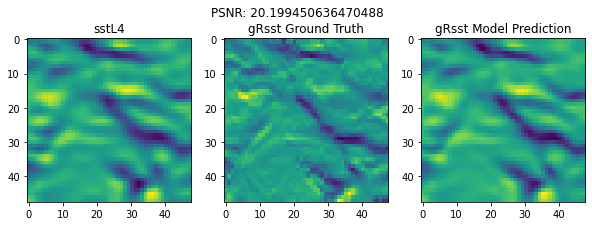

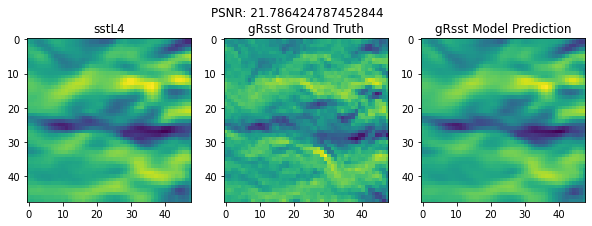

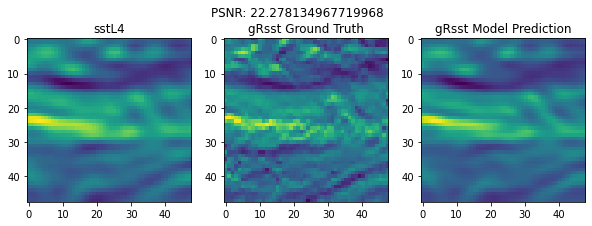

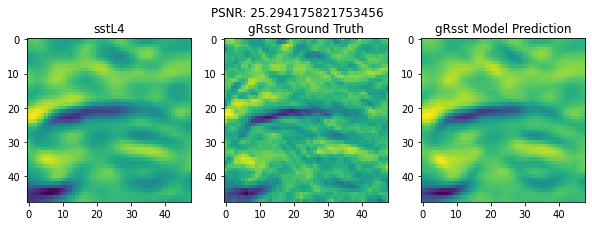

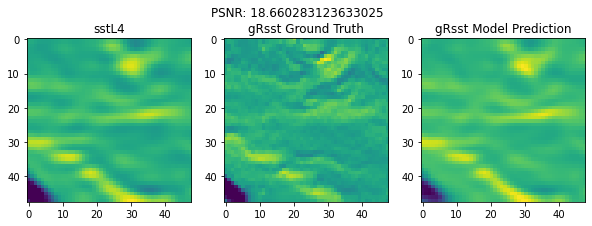

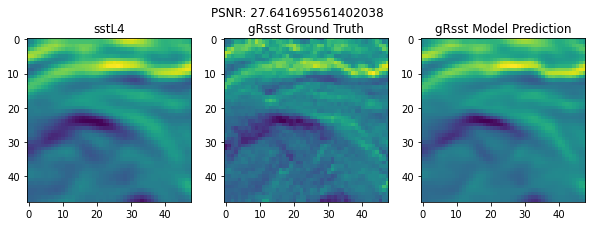

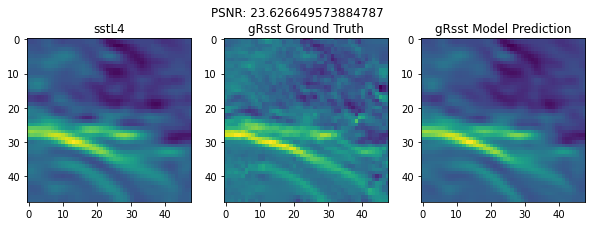

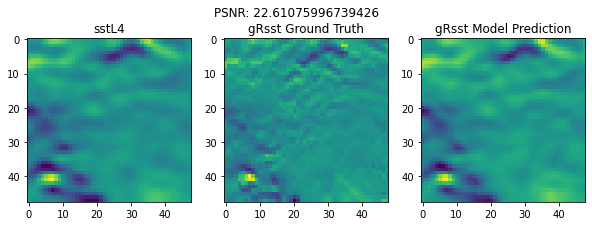

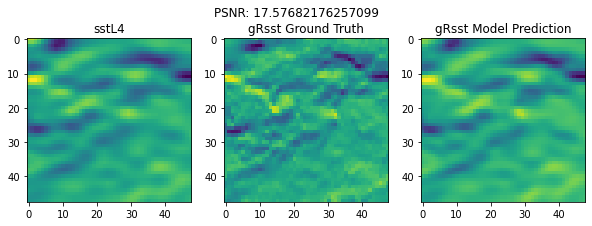

In [58]:
#model = best_model
from skimage.metrics import structural_similarity as ssim
model.to(device)
input_data, output_data = next(iter(test_loader)) # single batch

for i in range(len(input_data)):
    sample_input = input_data[i].to(device)
    sample_output = np.expand_dims(output_data[i].detach().cpu().numpy(),axis=0)
    model.eval()
    with torch.no_grad():
        sample_prediction = model(sample_input).detach().cpu().numpy()
        sample_prediction = np.expand_dims(sample_prediction,axis=0)
    sample_input = sample_input.detach().cpu().numpy()
    psnr = PSNR(model, sample_output, sample_prediction)
    #ssim = ssim(sample_output, sample_prediction,data_range=sample_prediction.max() - sample_prediction.min(),multichannel=True,win_size=??)
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(sample_input[1])
    ax[0].set_title('sstL4')
    ax[1].imshow(sample_output[0,1]) 
    ax[1].set_title('gRsst Ground Truth')
    ax[2].imshow(sample_prediction[0,1]) 
    ax[2].set_title('gRsst Model Prediction')
    fig.suptitle(f'PSNR: {psnr}', y=0.66)
    fig.savefig('plots/SRCNN_example_output')
    plt.show()

### GAN Train
**EXPERIMENTAL**

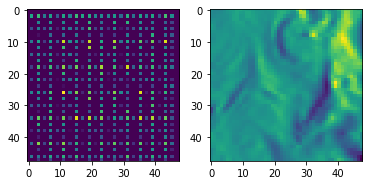

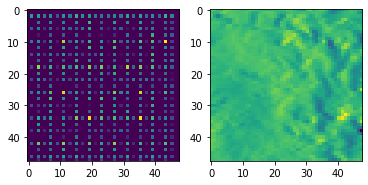

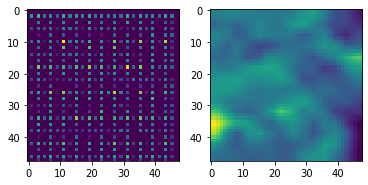

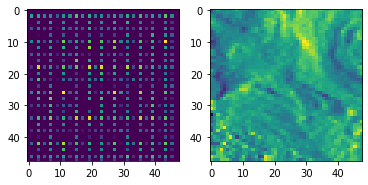

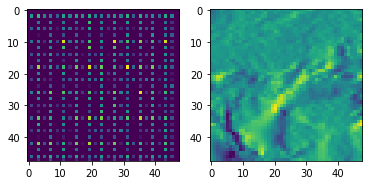

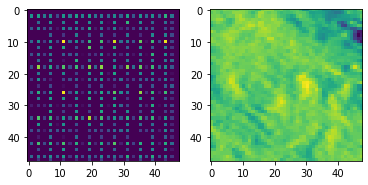

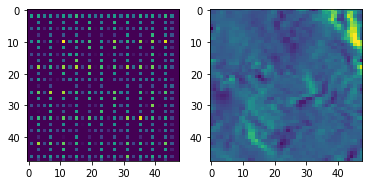

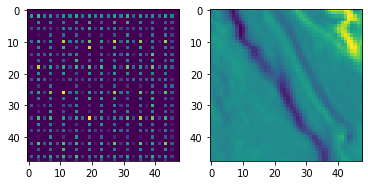

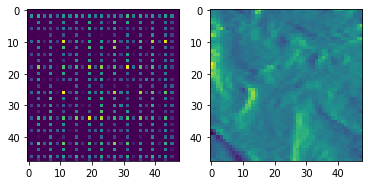

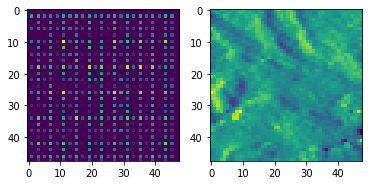

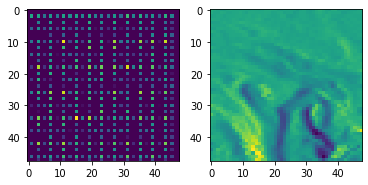

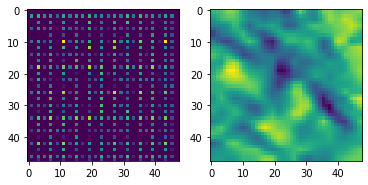

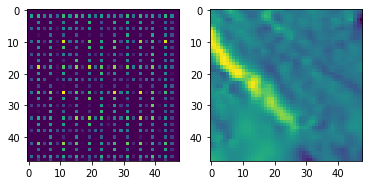

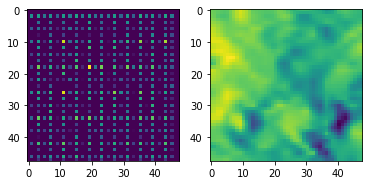

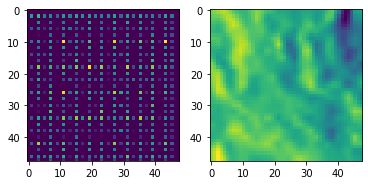

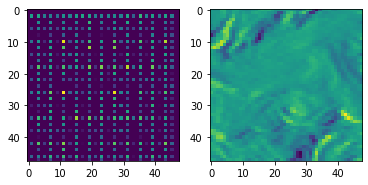

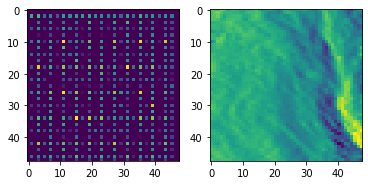

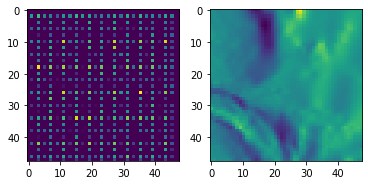

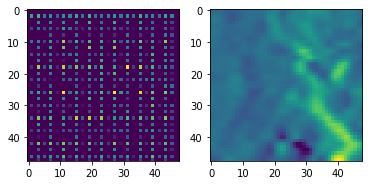

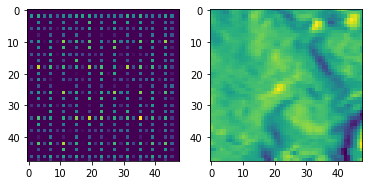

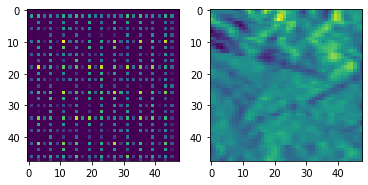

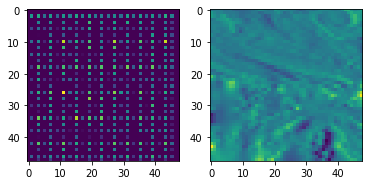

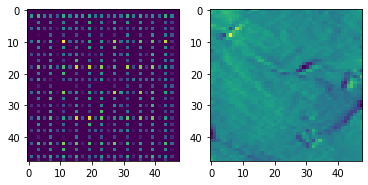

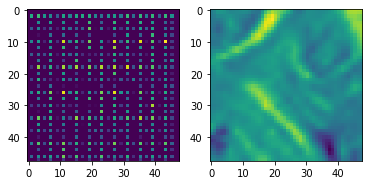

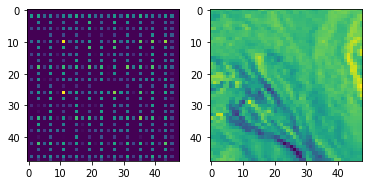

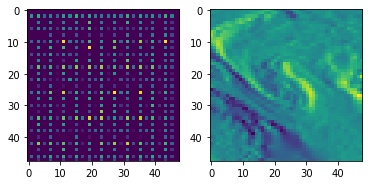

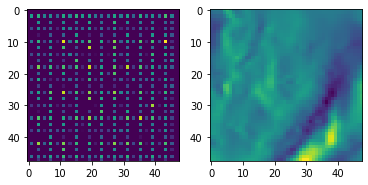

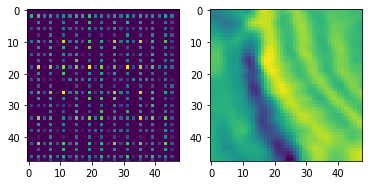

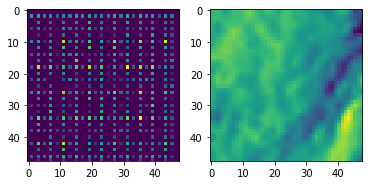

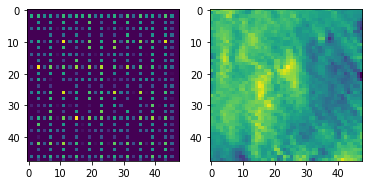

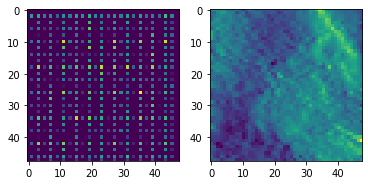

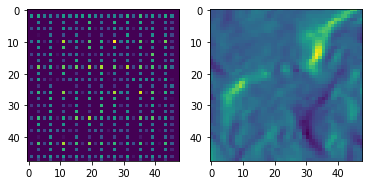

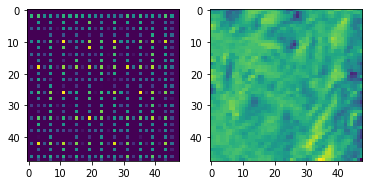

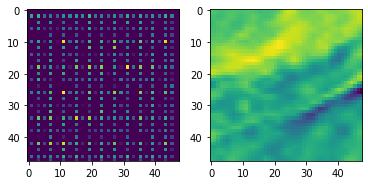

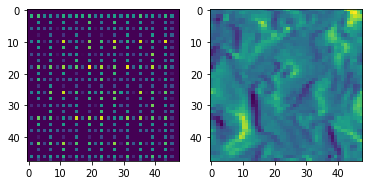

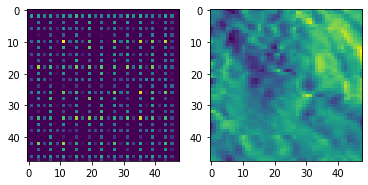

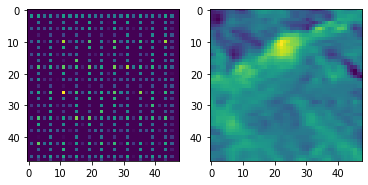

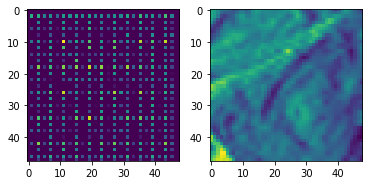

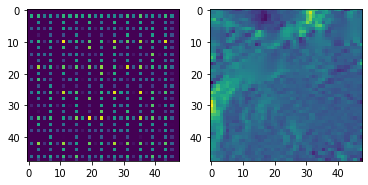

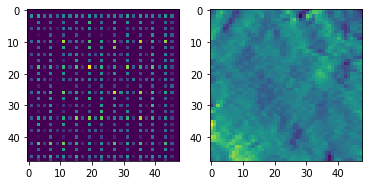

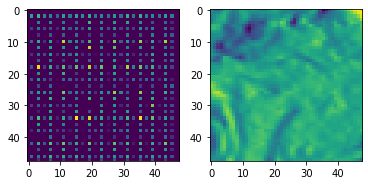

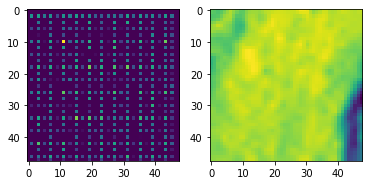

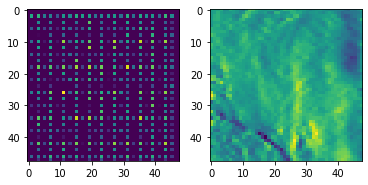

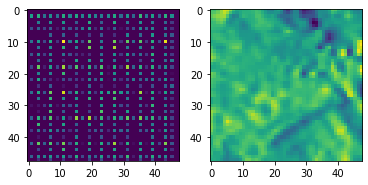

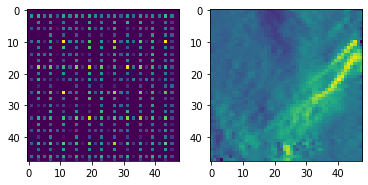

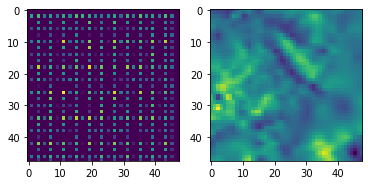

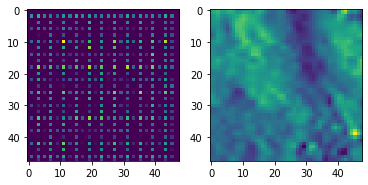

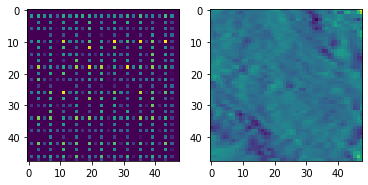

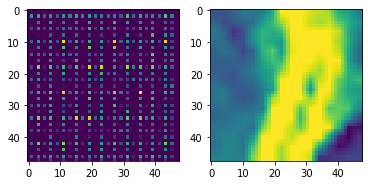

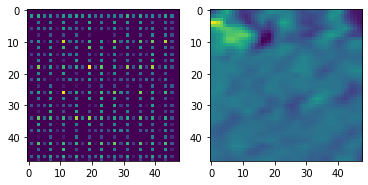

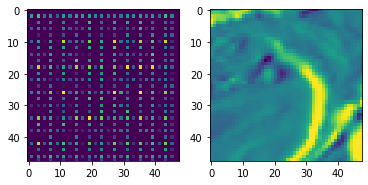

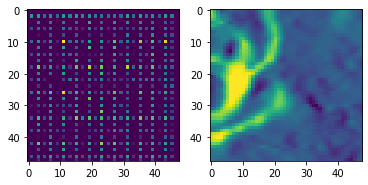

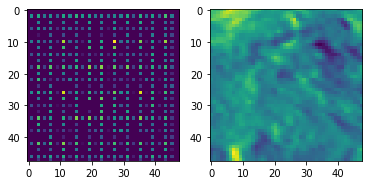

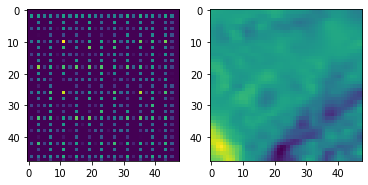

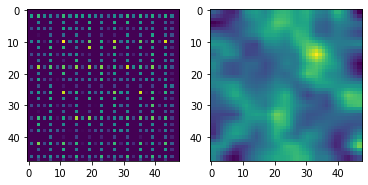

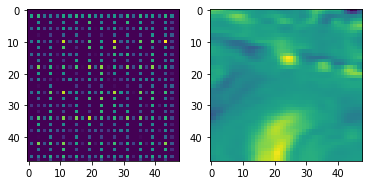

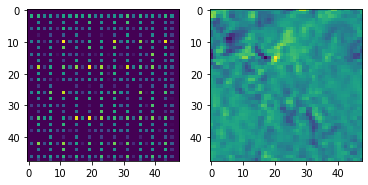

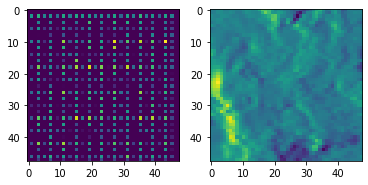

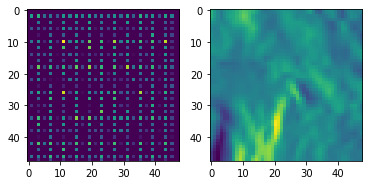

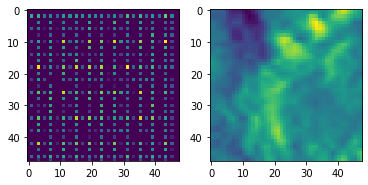

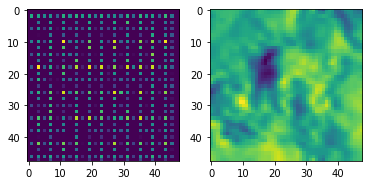

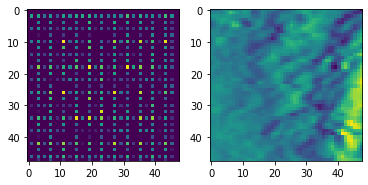

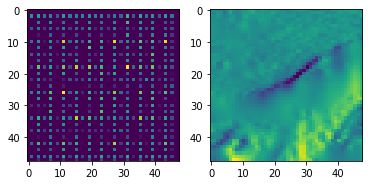

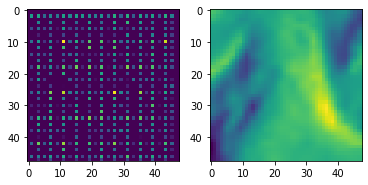

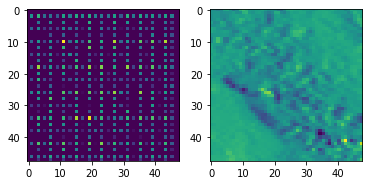

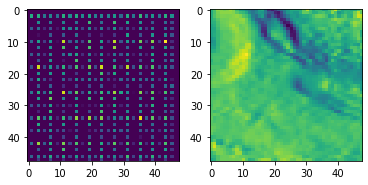

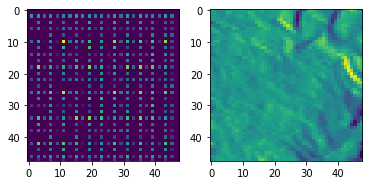

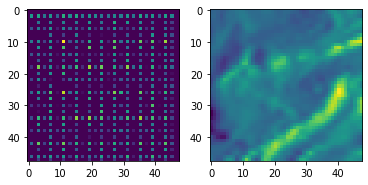

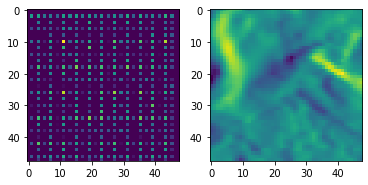

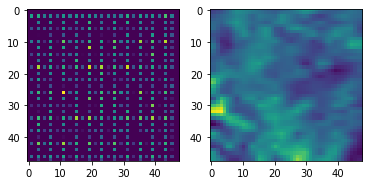

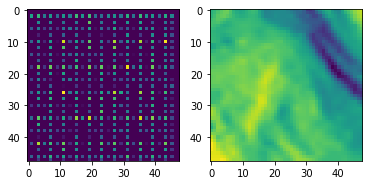

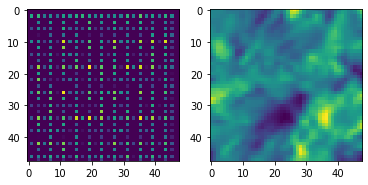

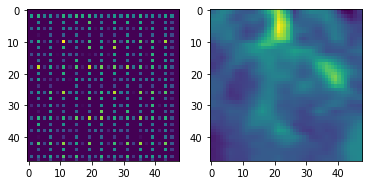

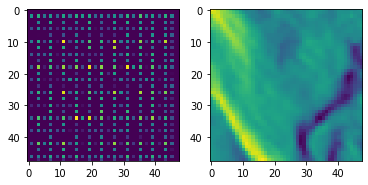

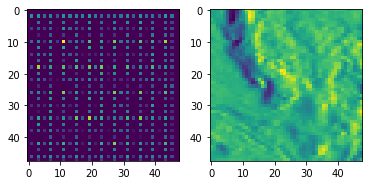

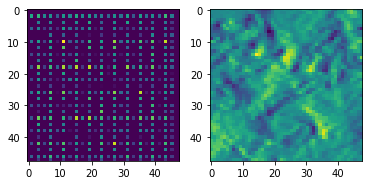

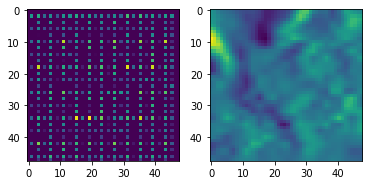

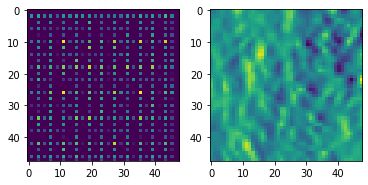

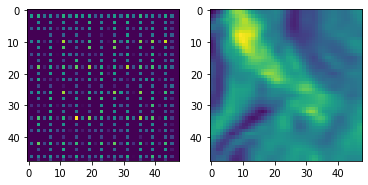

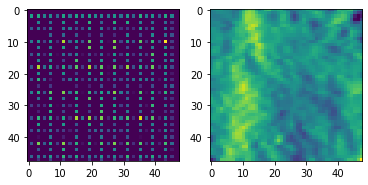

EPOCH:1, gen_loss:0.0026951630134135485, disc_loss:9.271580031500193e-11, psnr:13.533317938721495


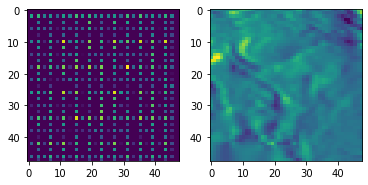

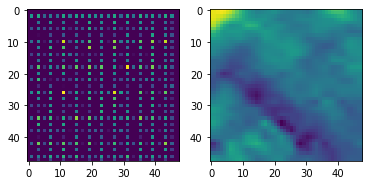

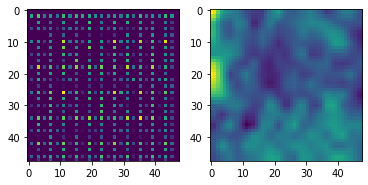

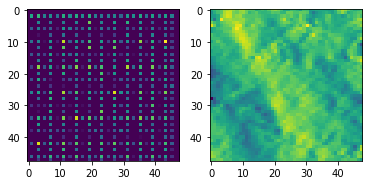

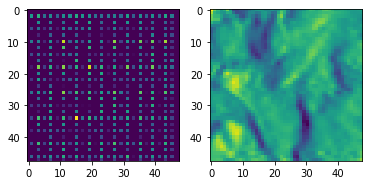

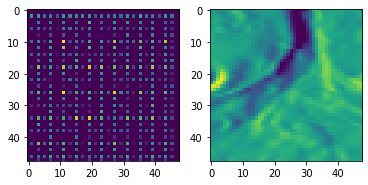

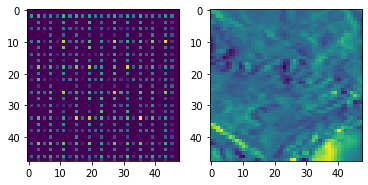

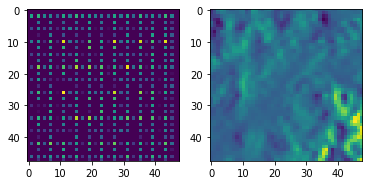

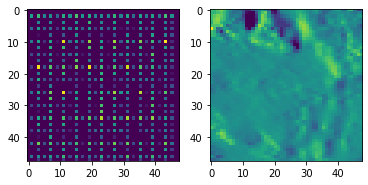

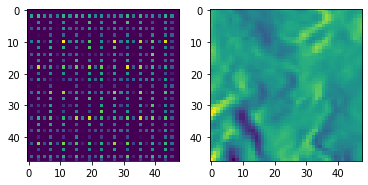

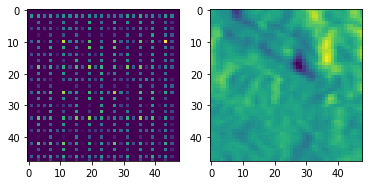

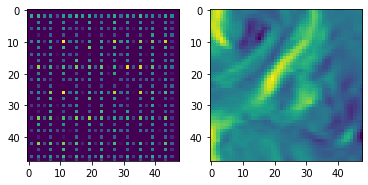

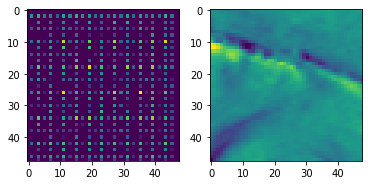

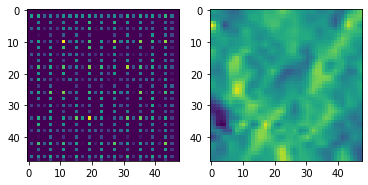

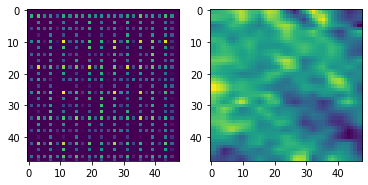

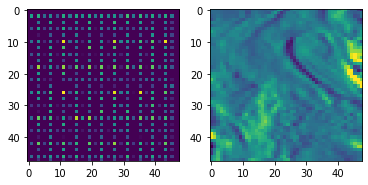

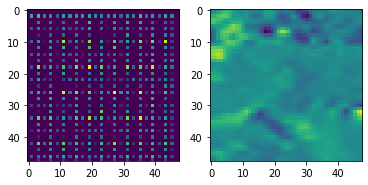

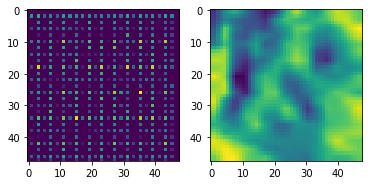

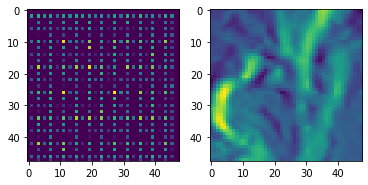

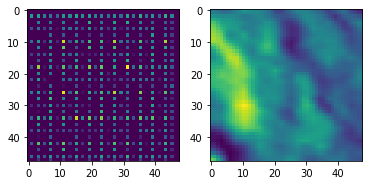

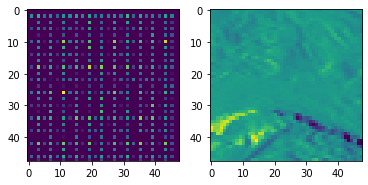

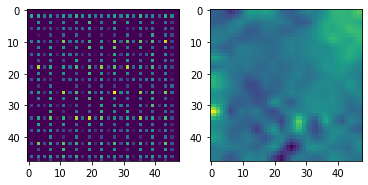

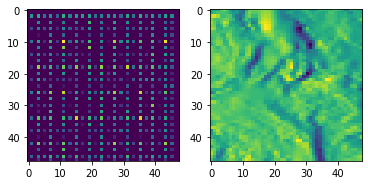

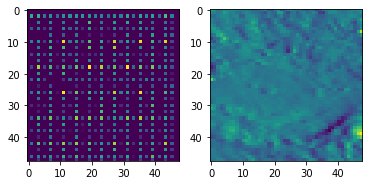

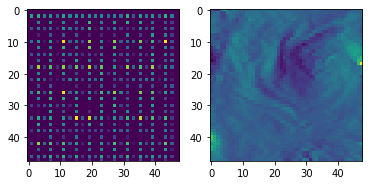

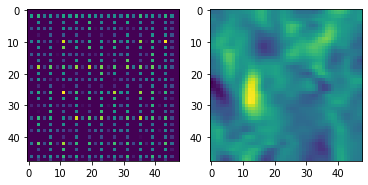

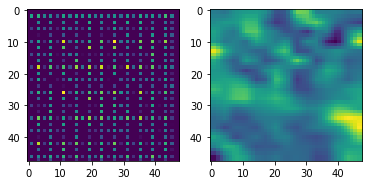

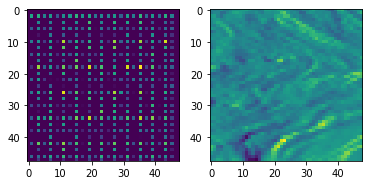

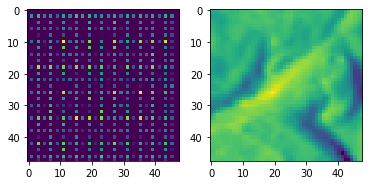

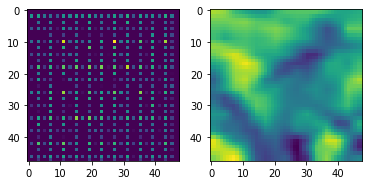

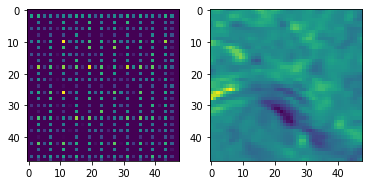

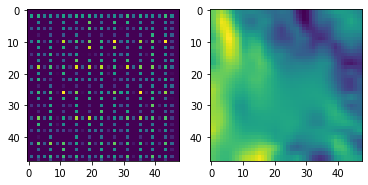

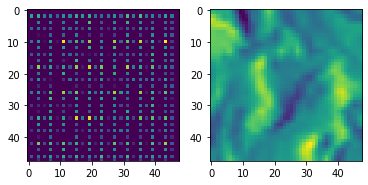

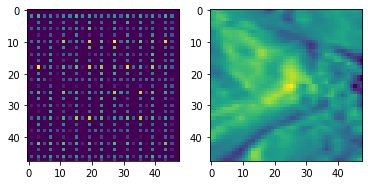

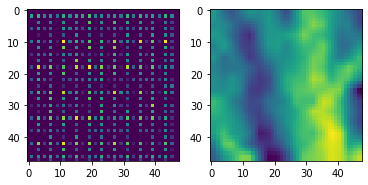

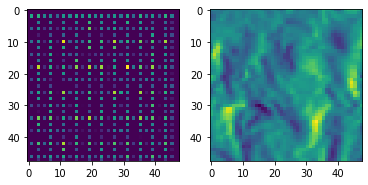

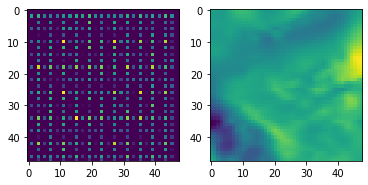

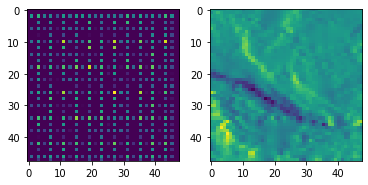

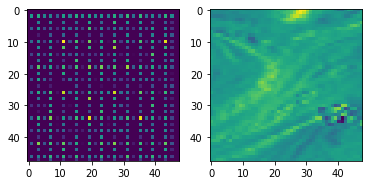

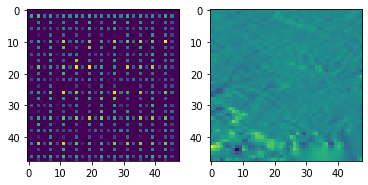

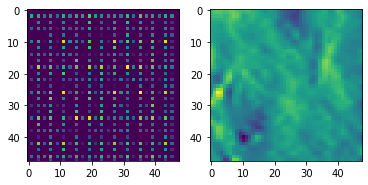

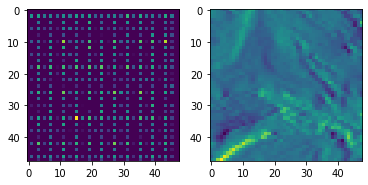

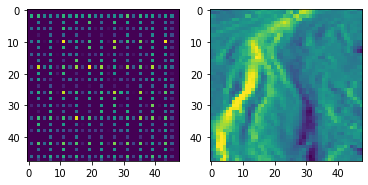

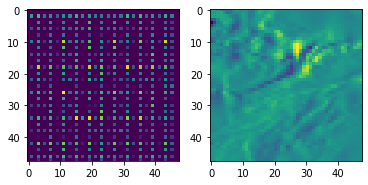

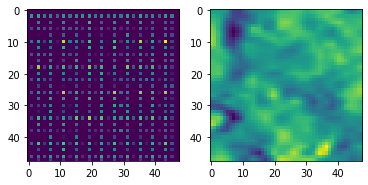

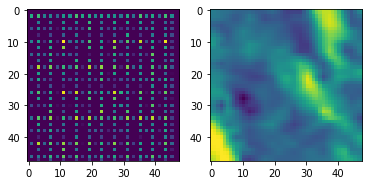

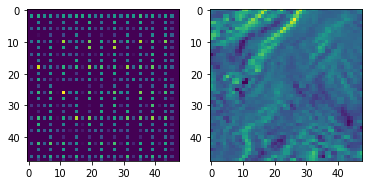

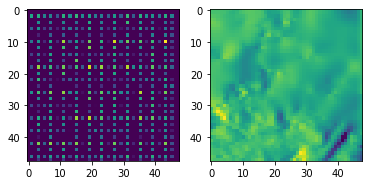

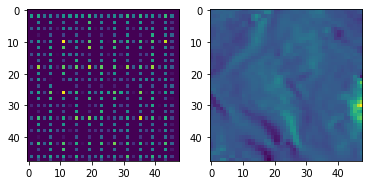

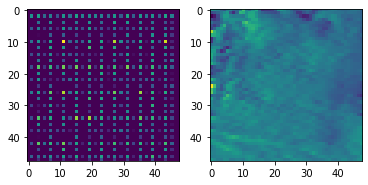

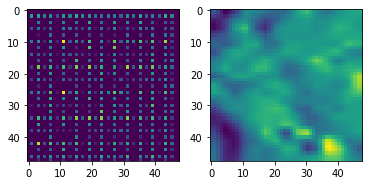

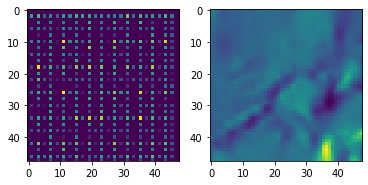

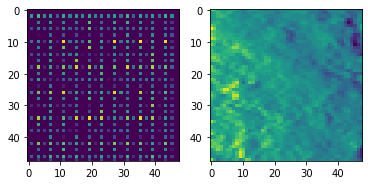

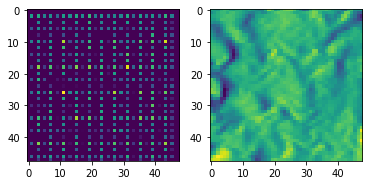

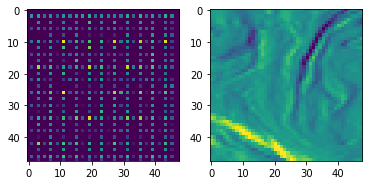

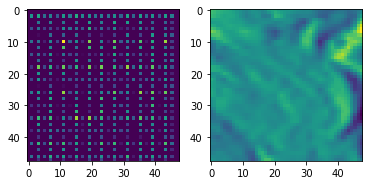

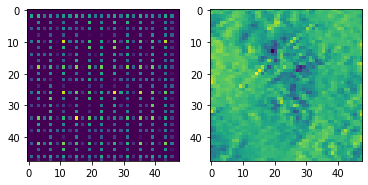

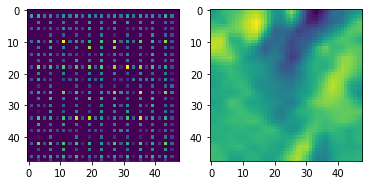

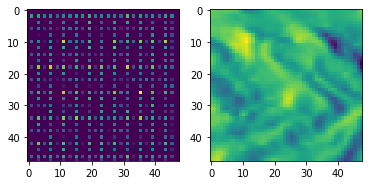

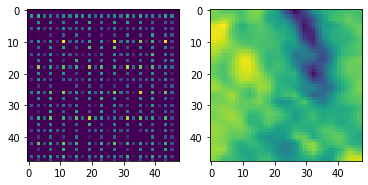

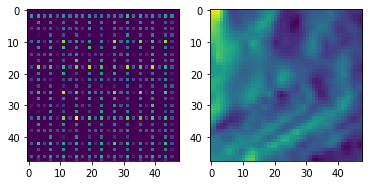

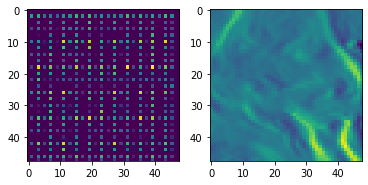

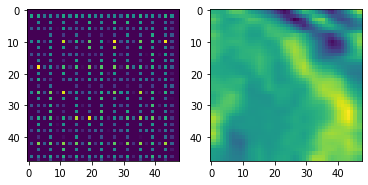

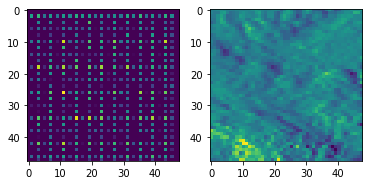

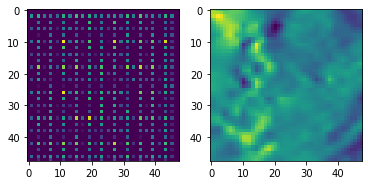

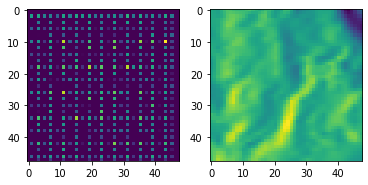

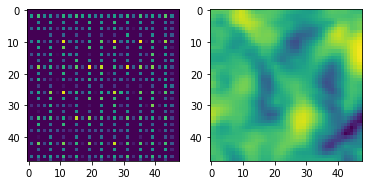

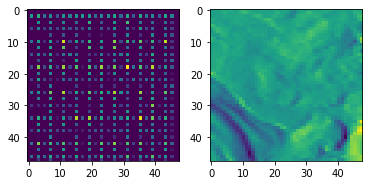

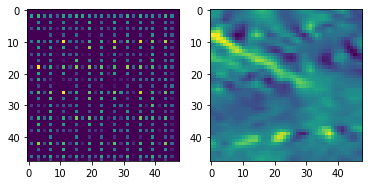

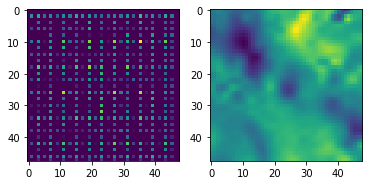

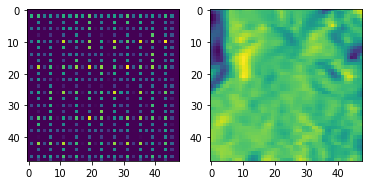

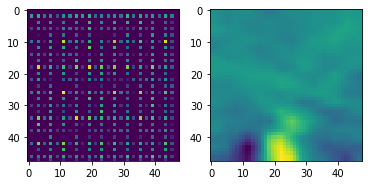

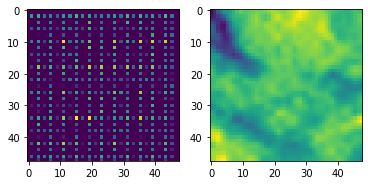

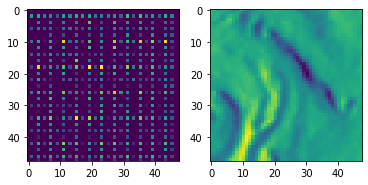

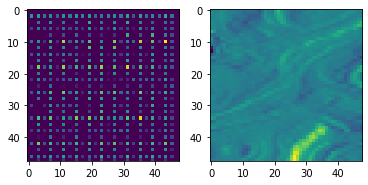

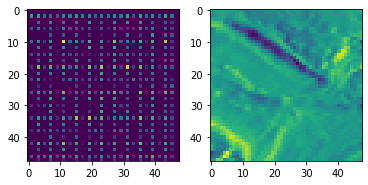

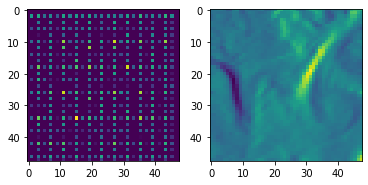

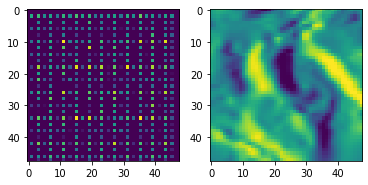

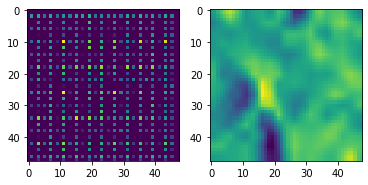

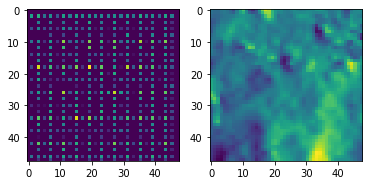

EPOCH:2, gen_loss:0.002948044566437602, disc_loss:2.3178944874580054e-11, psnr:13.527351678556641


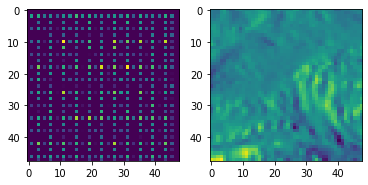

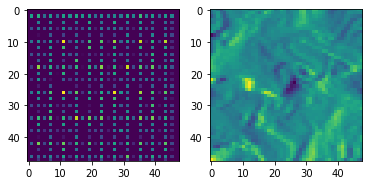

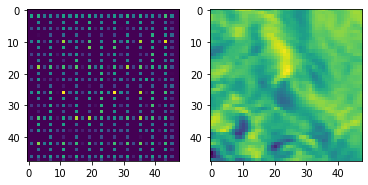

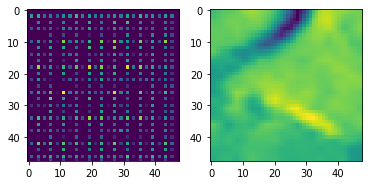

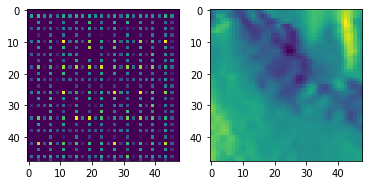

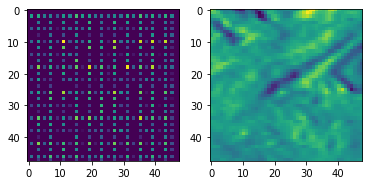

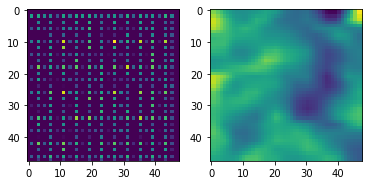

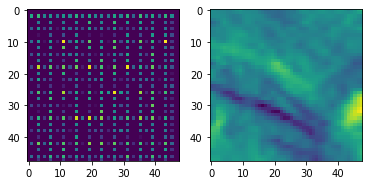

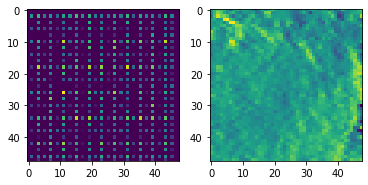

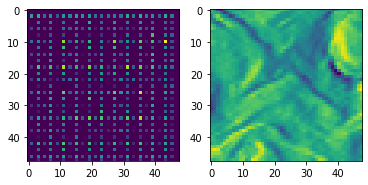

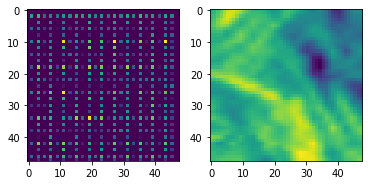

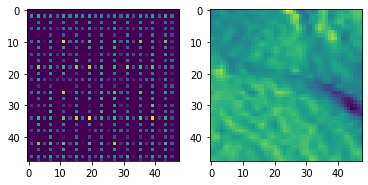

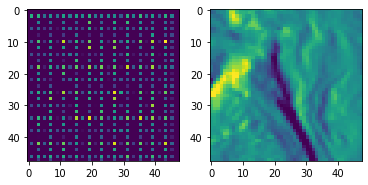

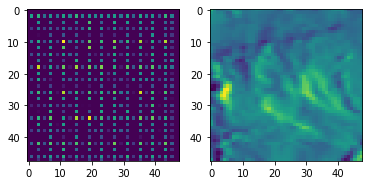

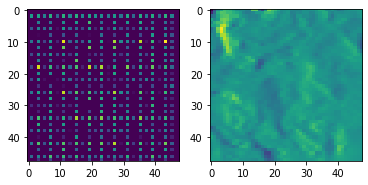

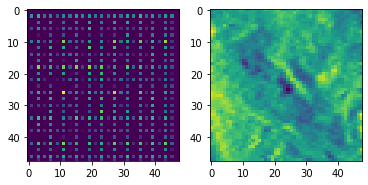

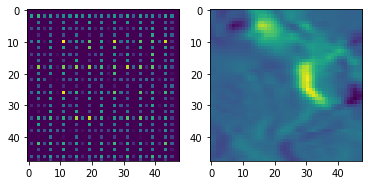

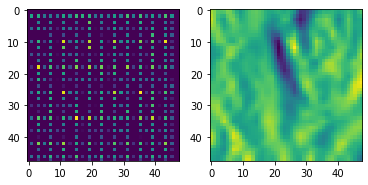

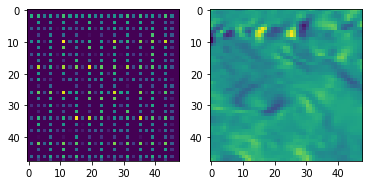

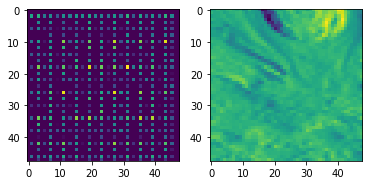

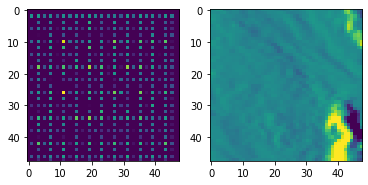

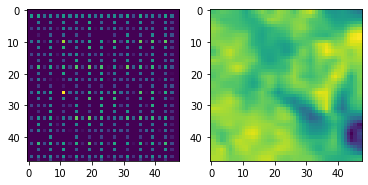

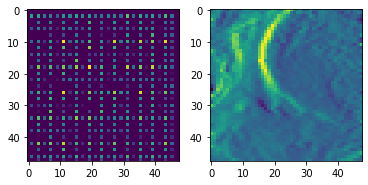

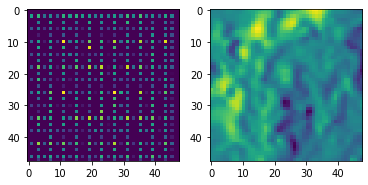

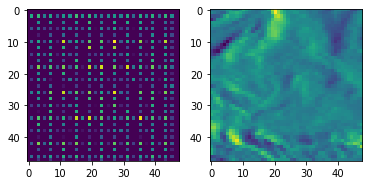

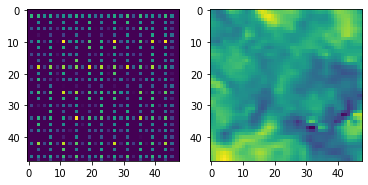

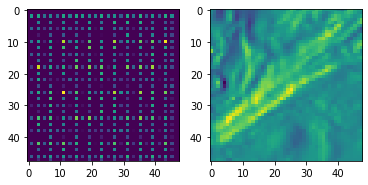

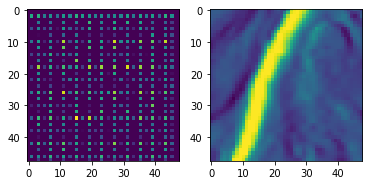

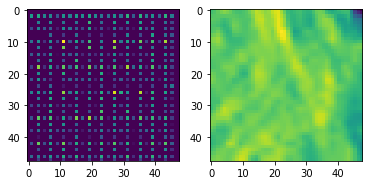

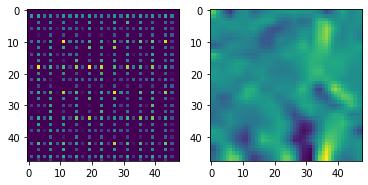

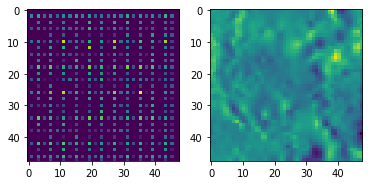

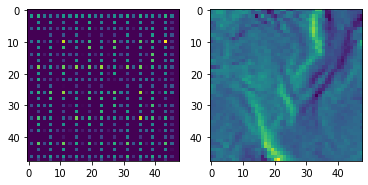

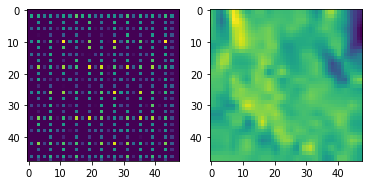

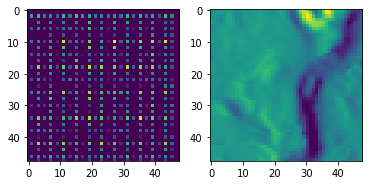

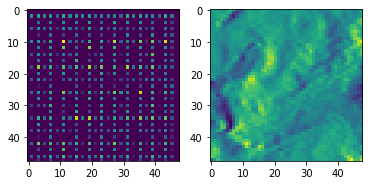

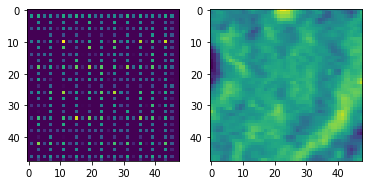

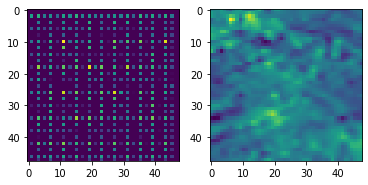

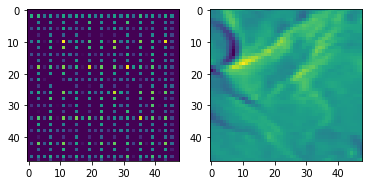

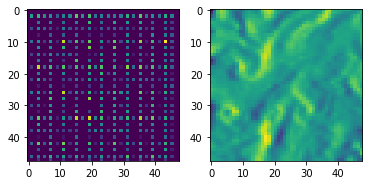

KeyboardInterrupt: 

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gen = Generator(2,2).to(device)
disc = Discriminator(2).to(device)
lr = 1E-4
opt_gen = Adam(gen.parameters(), lr=lr)
opt_disc = Adam(disc.parameters(), lr=lr)
criterion = nn.BCELoss()

num_epochs = 100
for epoch in range(num_epochs):
    running_psnr = 0
    running_lossD = 0
    running_lossG = 0
    for i, (train_input, train_true) in enumerate(train_loader, 0):
        train_input = train_input.to(device)
        train_true = train_true.to(device)
        disc.train()
        gen.train()
        ## Discriminator Train
        fake = gen(train_input) # generate fake data
        disc_real = disc(train_true) # discriminator pred. on real data
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # -max(log(D_real))
        disc_fake = disc(fake.detach())
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # -max(log(1-D(G(z))))
        lossD = (lossD_real+lossD_fake)/2
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()
        ## Generator Train 
        output = disc(fake.detach())
        lossG = criterion(output, torch.ones_like(output)) # -max log(D(G(z)))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        ## Running metrics
        running_psnr += PSNR(gen, train_true.detach().cpu().numpy(), fake.detach().cpu().numpy()) # compute PSNR on generated data
        running_lossG += lossG.detach().cpu().numpy()
        running_lossD += lossD.detach().cpu().numpy()
        if i%64==63:
            fig,ax=plt.subplots(1,2)
            ax[0].imshow(fake.detach().cpu().numpy()[0,0])
            ax[1].imshow(train_true.detach().cpu().numpy()[0,0])
            plt.show()
    print(f'EPOCH:{epoch+1}, gen_loss:{lossG/len(train_loader)}, disc_loss:{lossD/len(train_loader)}, psnr:{running_psnr/len(train_loader)}')

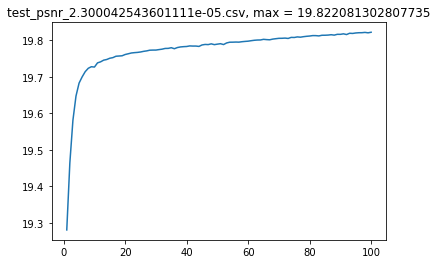

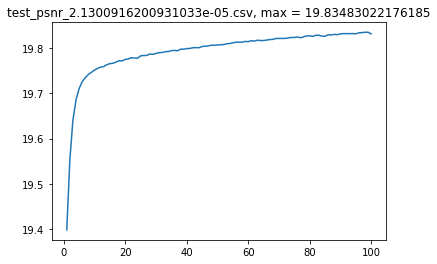

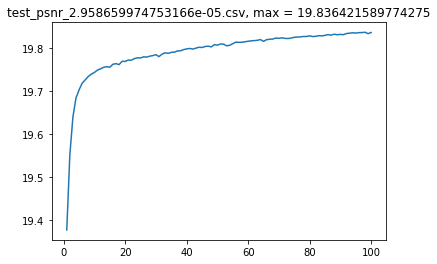

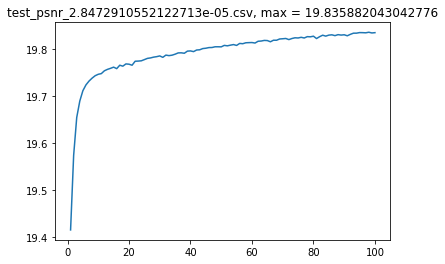

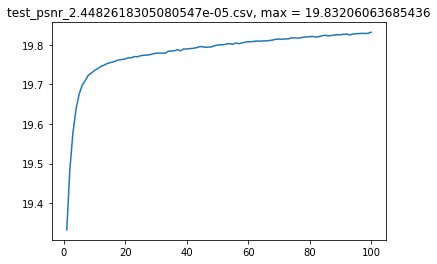

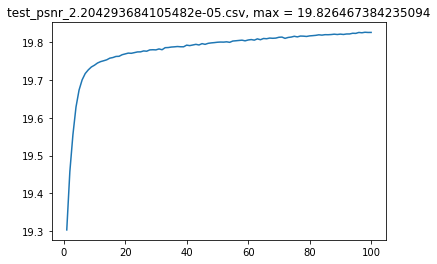

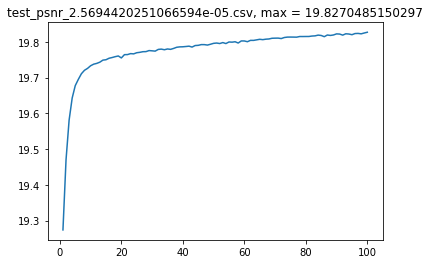

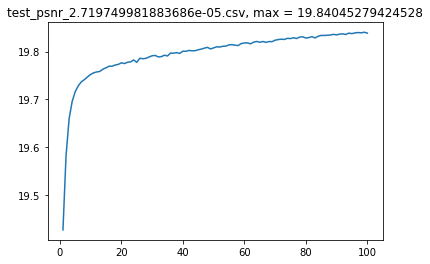

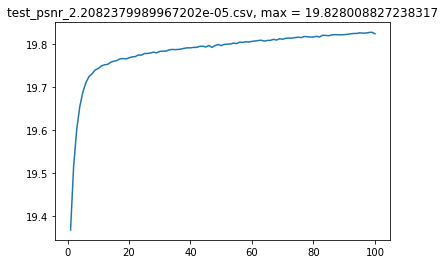

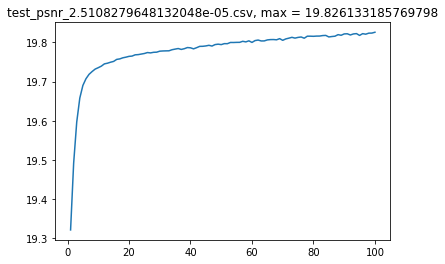

In [40]:
path = 'models/edsr_hp_search'

file_list = []

for elem in os.listdir(path):
    if elem.startswith('test'):
        file_list.append(os.path.join(path,elem))

for i,file in enumerate(file_list): 
    data = np.loadtxt(file,delimiter=',')
    data = np.transpose(data)
    plt.plot(data[0],data[1])
    plt.title(f'{os.path.basename(file)}, max = {np.max(data[1])}')
    plt.show()